In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']=".97"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
#import pyccl as ccl


%load_ext autoreload
%autoreload 2




/tmp/ipykernel_1649586/3649666895.py:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# !pip install -Uq tfp-nightly[jax] > /dev/null
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels




In [3]:
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 2, 32
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 13.0, 14.5, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 3, 7, 24
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [4]:
# lgM_bin_min = jnp.array([11.7, 12.7, 13.3, 13.7, 14.3, 14.7])
# lgM_bin_max = jnp.array([12.0, 13.0, 13.6, 14.0, 14.7, 15.0])

z_array_fit = np.array([0.001, 0.5, 1.0])
snap_num_fit = np.array([32, 28, 26])

# z_array_fit = np.array([0.001])
# snap_num_fit = np.array([32])

# z_array_fit = np.array([0.5])
# snap_num_fit = np.array([28])

# z_array_fit = np.array([1.0])
# snap_num_fit = np.array([26])

lgM_bin_min = jnp.array([13.0, 13.5, 14.0])
lgM_bin_max = jnp.array([13.5, 14.0, 14.5])

lgM_bin_mean = 0.5*(lgM_bin_min + lgM_bin_max)
# zmean = 0.0015

import pickle as pk
df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_lowTAGN_zs_32.pkl','rb'))
# df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_32.pkl','rb'))
# df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profs_highT.pk','rb'))
# print(df_at.keys())


x_array_data = df_at['r_r200c']

xmin, xmax = 0.05, 1.5
indselx = np.where((x_array_data > xmin) & (x_array_data < xmax))[0]
x_array_data = x_array_data[indselx]

# lgmass_all = df_at['lgmass_all']
rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
Pe_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

sig_rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
sig_ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
sig_Pe_gas_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

for jz in range(len(z_array_fit)):
    snap_num_jz = snap_num_fit[jz]
    print('snap_num_jz = ' + str(snap_num_jz))
    df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_lowTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))
    # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
    M_dmo_all = df_at['M_dmo']
    rho_dmb_all = df_at['rho_dmb_all']
    # rho_gas_all = df_at['rho_gas_all']
    ne_all = df_at['ne_all']    
    Pe_all = df_at['P_all']
    lgM_dmo_all = np.log10(M_dmo_all)
    for jM in range(len(lgM_bin_min)):
        indselM = np.where((lgM_dmo_all > lgM_bin_min[jM]) & (lgM_dmo_all < lgM_bin_max[jM]))[0]
        print(indselM.shape)
        rho_dmb_dv[jz, jM, :] = np.mean(rho_dmb_all[indselM,:], axis=0)[indselx]
        ne_dv[jz, jM, :] = np.mean(ne_all[indselM,:], axis=0)[indselx]
        Pe_dv[jz, jM, :] = np.mean(Pe_all[indselM,:], axis=0)[indselx]

        # if np.any(np.isnan(rho_dmb_dv[jM,:])):
        #     print('rho_dmb_dv in jM, jz' + str(jM) + ',' + str(jz) + 'has nans')
        # if np.any(np.isnan(rho_gas_dv[jM,:])):
        #     print('rho_gas_dv in jM, jz' + str(jM) + ',' + str(jz) + 'has nans')
        # if np.any(np.isnan(P_gas_dv[jM,:])):
        #     print('P_gas_dv in jM, jz' + str(jM) + ',' + str(jz) + 'has nans')
        #     print(P_gas_dv[jM,:])

        sig_rho_dmb_dv[jz, jM, :] = np.std(rho_dmb_all[indselM,:], axis=0)[indselx]
        sig_ne_dv[jz, jM, :] = np.std(ne_all[indselM,:], axis=0)[indselx]
        sig_Pe_gas_dv[jz, jM, :] = np.std(Pe_all[indselM,:], axis=0)[indselx]



# x_array_data = jnp.logspace(jnp.log10(0.01), jnp.log10(3), 20)
# log10_x_array_data_edges = jnp.array([-2.,-1.87379263,-1.74758526,-1.62137789,-1.49517052,-1.36896316,-1.24275579,-1.11654842,-0.99034105,-0.86413368,-0.73792631,-0.61171894,-0.48551157,-0.3593042,-0.23309684,-0.10688947,0.0193179,0.14552527,0.27173264,0.39794001])
# x_array_data_edges = 10**log10_x_array_data_edges
# x_array_data_edges_min = x_array_data_edges[:-1]
# x_array_data_edges_max = x_array_data_edges[1:]
# x_array_data = 10**(0.5*(log10_x_array_data_edges[1:] + log10_x_array_data_edges[:-1]))

# x_array_data = df_at['r_r200c']

# rho_dmb_dv = np.array([df_at['rho_tot_low'], df_at['rho_tot_high']])
# rho_gas_dv = np.array([df_at['rho_gas_low'], df_at['rho_gas_high']])
# P_gas_dv = np.array([df_at['Pth_low'], df_at['Pth_high']])
dmb_dv_flatten = rho_dmb_dv.flatten()
gas_dv_flatten = ne_dv.flatten()
Pgas_dv_flatten = Pe_dv.flatten()
sig_dmb_dv_flatten = sig_rho_dmb_dv.flatten()
sig_gas_dv_flatten = sig_ne_dv.flatten()
sig_Pgas_dv_flatten = sig_Pe_gas_dv.flatten()

dv_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pgas_dv_flatten))
ind_finite = jnp.where(jnp.isfinite(dv_combined))[0]
dv_combined = dv_combined[ind_finite]
# sigma_value_combined = 0.05*dv_combined
sigma_value_combined = jnp.concatenate((sig_dmb_dv_flatten, sig_gas_dv_flatten, sig_Pgas_dv_flatten))
sigma_value_combined = sigma_value_combined[ind_finite]
# sigma_value_combined = 0.05*dv_combined


# sigma_value_combined = sigma_value_combined/dv_combined
# dv_combined = jnp.log(dv_combined)

cov_combined = jnp.diag(sigma_value_combined**2)
# precision_combined = jnp.linalg.inv(cov_combined)
precision_combined = jnp.diag(1./sigma_value_combined**2)




snap_num_jz = 32
(208,)
(60,)
(17,)
snap_num_jz = 28
(164,)
(51,)
(11,)
snap_num_jz = 26
(123,)
(22,)
(4,)


Text(0.5, 0, '$r/r_{200c}$')

<Figure size 640x480 with 0 Axes>

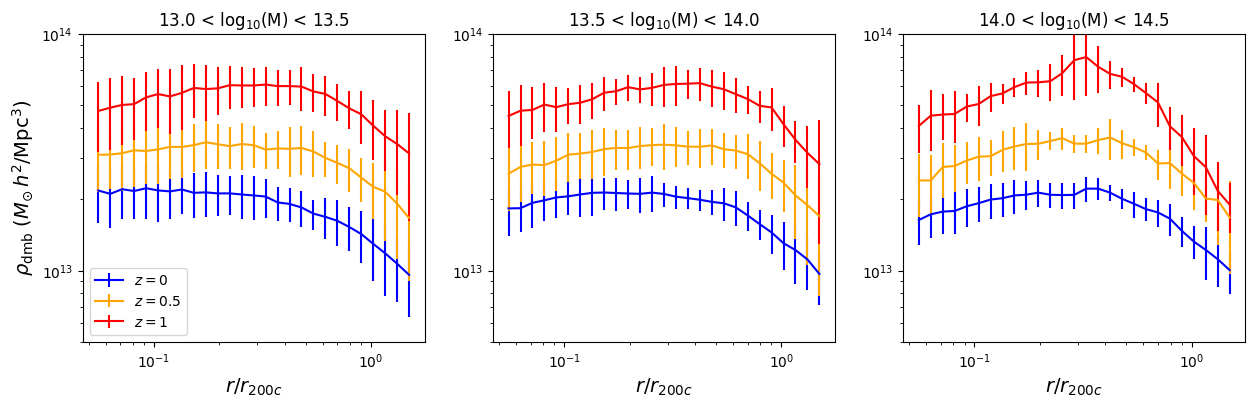

In [5]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
indM = 0
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,indM,:], (x_array_data**2)*sig_rho_dmb_dv[0,indM,:],ls='-' , color='b', label=r'$z=0$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[1,indM,:], (x_array_data**2)*sig_rho_dmb_dv[1,indM,:],ls='-', color='orange', label=r'$z=0.5$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[2,indM,:], (x_array_data**2)*sig_rho_dmb_dv[2,indM,:],ls='-', color='r', label=r'$z=1$')
pl.ylim(5e12, 1e14)


# pl.title('Total density')
pl.title('13.0 < log$_{10}$(M) < 13.5')
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
# indM = 0
# pl.errorbar(x_array_data, rho_gas_dv[0,indM,:], sig_rho_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[1,indM,:], sig_rho_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[2,indM,:], sig_rho_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 1
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,indM,:], (x_array_data**2)*sig_rho_dmb_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[1,indM,:], (x_array_data**2)*sig_rho_dmb_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[2,indM,:], (x_array_data**2)*sig_rho_dmb_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
pl.ylim(5e12, 1e14)
# pl.title('Gas density')
pl.title('13.5 < log$_{10}$(M) < 14.0')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e11, 1e15)
# pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
# indM = 0
# pl.errorbar(x_array_data, P_gas_dv[0,indM,:], sig_P_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[1,indM,:], sig_P_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[2,indM,:], sig_P_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 2
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,indM,:], (x_array_data**2)*sig_rho_dmb_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[1,indM,:], (x_array_data**2)*sig_rho_dmb_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[2,indM,:], (x_array_data**2)*sig_rho_dmb_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')


# pl.title('Electron pressure')
pl.title('14.0 < log$_{10}$(M) < 14.5')
pl.ylim(5e12, 1e14)
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()








Text(0.5, 0, '$r/r_{200c}$')

<Figure size 640x480 with 0 Axes>

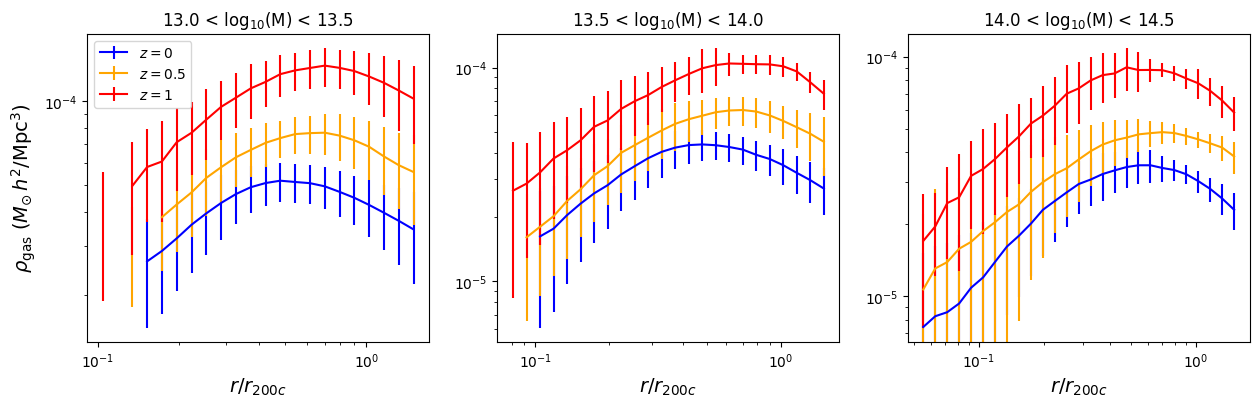

In [6]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
indM = 0
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[0,indM,:], (x_array_data**2)*sig_ne_dv[0,indM,:],ls='-' , color='b', label=r'$z=0$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[1,indM,:], (x_array_data**2)*sig_ne_dv[1,indM,:],ls='-', color='orange', label=r'$z=0.5$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[2,indM,:], (x_array_data**2)*sig_ne_dv[2,indM,:],ls='-', color='r', label=r'$z=1$')
# pl.ylim(5e12, 1e14)
# pl.ylim(2e11, 1e13)

# pl.title('Total density')
pl.title('13.0 < log$_{10}$(M) < 13.5')
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
# pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# add subplot to the center:
pl.subplot(1, 3, 2)
# indM = 0
# pl.errorbar(x_array_data, rho_gas_dv[0,indM,:], sig_rho_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[1,indM,:], sig_rho_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[2,indM,:], sig_rho_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 1
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[0,indM,:], (x_array_data**2)*sig_ne_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[1,indM,:], (x_array_data**2)*sig_ne_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[2,indM,:], (x_array_data**2)*sig_ne_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
# pl.ylim(5e12, 1e14)
# pl.ylim(2e11, 1e13)
# pl.title('Gas density')
pl.title('13.5 < log$_{10}$(M) < 14.0')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e11, 1e15)
# pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
# indM = 0
# pl.errorbar(x_array_data, P_gas_dv[0,indM,:], sig_P_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[1,indM,:], sig_P_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[2,indM,:], sig_P_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 2
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[0,indM,:], (x_array_data**2)*sig_ne_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[1,indM,:], (x_array_data**2)*sig_ne_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[2,indM,:], (x_array_data**2)*sig_ne_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')


# pl.title('Electron pressure')
pl.title('14.0 < log$_{10}$(M) < 14.5')
# pl.ylim(2e11, 1e13)
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()








Text(0.5, 0, '$r/r_{200c}$')

<Figure size 640x480 with 0 Axes>

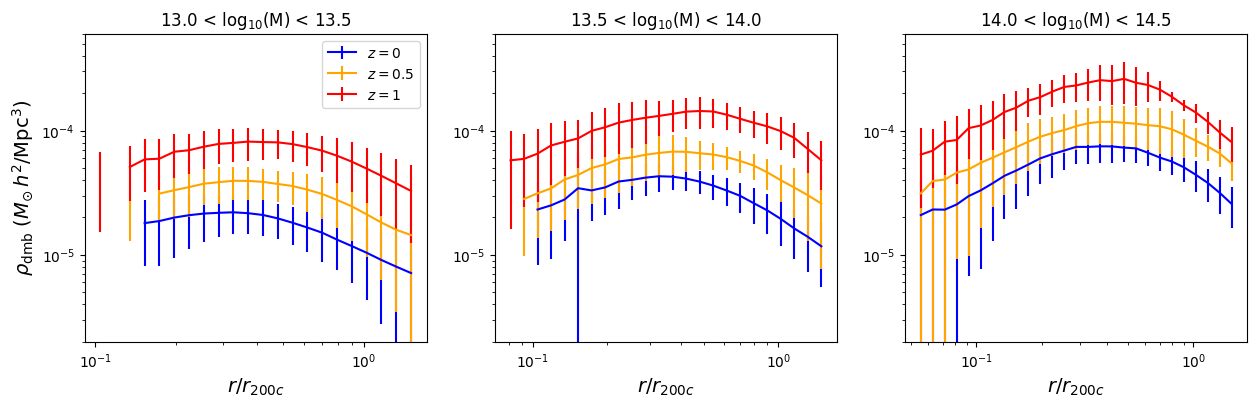

In [7]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
indM = 0
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[0,indM,:], (x_array_data**2)*sig_Pe_gas_dv[0,indM,:],ls='-' , color='b', label=r'$z=0$')
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[1,indM,:], (x_array_data**2)*sig_Pe_gas_dv[1,indM,:],ls='-', color='orange', label=r'$z=0.5$')
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[2,indM,:], (x_array_data**2)*sig_Pe_gas_dv[2,indM,:],ls='-', color='r', label=r'$z=1$')
# pl.ylim(5e12, 1e14)
# pl.ylim(2e11, 1e13)
pl.ylim(2e-6, 6e-4)
# pl.title('Total density')
pl.title('13.0 < log$_{10}$(M) < 13.5')
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
# indM = 0
# pl.errorbar(x_array_data, rho_gas_dv[0,indM,:], sig_rho_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[1,indM,:], sig_rho_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[2,indM,:], sig_rho_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 1
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[0,indM,:], (x_array_data**2)*sig_Pe_gas_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[1,indM,:], (x_array_data**2)*sig_Pe_gas_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[2,indM,:], (x_array_data**2)*sig_Pe_gas_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
# pl.ylim(5e12, 1e14)
pl.ylim(2e-6, 6e-4)
# pl.ylim(2e11, 1e13)
# pl.title('Gas density')
pl.title('13.5 < log$_{10}$(M) < 14.0')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e11, 1e15)
# pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
# indM = 0
# pl.errorbar(x_array_data, P_gas_dv[0,indM,:], sig_P_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[1,indM,:], sig_P_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[2,indM,:], sig_P_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 2
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[0,indM,:], (x_array_data**2)*sig_Pe_gas_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[1,indM,:], (x_array_data**2)*sig_Pe_gas_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*Pe_dv[2,indM,:], (x_array_data**2)*sig_Pe_gas_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')


# pl.title('Electron pressure')
pl.title('14.0 < log$_{10}$(M) < 14.5')
pl.ylim(2e-6, 6e-4)
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()








In [8]:
# import matplotlib.pyplot as pl

# lgM_array = np.linspace(13.0, 14.3, 64)
# theta_ej_0 = 4.0
# log10_Mstar0_theta_ej = 14
# nu_theta_ej_M = -0.2
# nu_theta_ej_z = 0.0

# theta_ej = theta_ej_0 * (10**lgM_array/10**log10_Mstar0_theta_ej)**nu_theta_ej_M

# pl.figure()
# pl.plot(lgM_array, theta_ej)




In [9]:
# pl.figure()
# # pl.errorbar(np.arange(len(dv_combined)), dv_combined, sigma_value_combined)
# jz, jM = 0, 0
# pl.errorbar(np.arange(len(rho_dmb_dv[jz, jM, :])), rho_dmb_dv[jz, jM, :], sig_rho_dmb_dv[jz, jM, :])

# jz, jM = 1, 0
# pl.errorbar(np.arange(len(rho_dmb_dv[jz, jM, :])), rho_dmb_dv[jz, jM, :], sig_rho_dmb_dv[jz, jM, :])


# jz, jM = 2, 0
# pl.errorbar(np.arange(len(rho_dmb_dv[jz, jM, :])), rho_dmb_dv[jz, jM, :], sig_rho_dmb_dv[jz, jM, :])
# pl.yscale('log')


# # P_gas_dv

In [10]:
# pl.figure()
# # pl.errorbar(np.arange(len(dv_combined)), dv_combined, sigma_value_combined)
# jz, jM = 0, 0
# pl.errorbar(np.arange(len(rho_dmb_dv[jz, jM, :])), P_gas_dv[jz, jM, :])


# # jz, jM = 1, 0
# # pl.errorbar(np.arange(len(rho_dmb_dv[jz, jM, :])), rho_dmb_dv[jz, jM, :], sig_rho_dmb_dv[jz, jM, :])

# jz, jM = 0, 0
# pl.errorbar(np.arange(len(rho_dmb_dv[jz, jM, :])), 8*P_gas_dv[jz, jM, :])


# jz, jM = 2, 0
# pl.errorbar(np.arange(len(rho_dmb_dv[jz, jM, :])), P_gas_dv[jz, jM, :])
# pl.yscale('log')

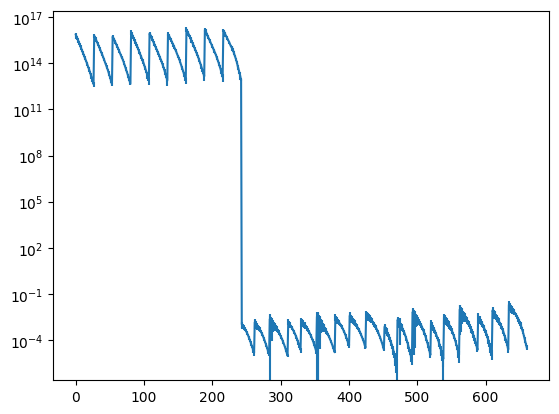

In [11]:
pl.figure()
pl.errorbar(np.arange(len(dv_combined)), dv_combined, sigma_value_combined)
pl.yscale('log')


# P_gas_dv

In [12]:
# pl.figure()
# pl.errorbar(np.arange(len(dv_combined)), dv_combined, sigma_value_combined, ls='', marker='o', ms=2.0)
# pl.yscale('log')
# # pl.ylim(1e13, 1e17)
# # pl.xlim(0,80)
# pl.ylim(1e-6, 1e-1)
# pl.xlim(480,700)
# pl.grid()




In [13]:
# pl.figure()
# pl.errorbar(np.arange(len(dv_combined)), dv_combined, sigma_value_combined, ls='', marker='o', ms=2.0)
# pl.yscale('log')
# # pl.ylim(1e13, 1e17)
# # pl.xlim(0,80)
# pl.ylim(1e-6, 1e-1)
# pl.xlim(480,700)
# pl.grid()


In [14]:
# # M_dmb_dv.shape


# from colossus.cosmology import cosmology
# from colossus.halo import concentration
# cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
# cmean_array_test = concentration.concentration(BCMP_test.M_array, '200c', zmean, model = 'diemer15')
# pl.figure()
# pl.plot(BCMP_test.M_array, cmean_array_test)
# pl.xscale('log')
# pl.xlim(10**13.7, 10**14.0)


In [15]:
from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)
# r_r200c_array_data = jnp.logspace(jnp.log10(0.01), jnp.log10(3), 20)

# BCMP_test_vary = BCM_18_wP(sim_params_dict, halo_params_dict)
# theory = BCMP_test_vary.rho_dmb_mat




In [16]:
# n_m_theory = np.zeros(len(lg10Mbins_all)-1)
# n_m_data = np.zeros(len(lg10Mbins_all)-1)

# # _ = pl.hist(np.log10(M_dmo_all), bins=100, range=(13, 15), histtype='step')


# for jM in range(len(lg10Mbins_all)-1):
#     indselM = np.where((np.log10(M_dmo_all) > lg10Mbins_all[jM]) & (np.log10(M_dmo_all) < lg10Mbins_all[jM+1]))[0]
#     n_m_data[jM] = len(indselM)/vol
#     # N_m_theory[jM] = 
#     Mmin_jM = 10**lg10Mbins_all[jM]
#     Mmax_jM = 10**lg10Mbins_all[jM+1]
#     M_array_jM = jnp.logspace(jnp.log10(Mmin_jM), jnp.log10(Mmax_jM), 6)
# dndlnM_th_jM = mass_function.massFunction(10**lg10Mbins_cent, zmean, mdef = '200c', model = 'tinker08', q_out='dndlnM')    
    # n_m_theory[jM] = jnp.trapz(dndlnM_th_jM, jnp.log(M_array_jM))

# pl.figure()
# pl.plot(lg10Mbins_cent, n_hist, label='data')
# pl.plot(lg10Mbins_cent, dndlnM_th_jM, label='theory')
# pl.yscale('log')

# pl.figure()
# # _ = pl.hist(np.log10(M_dmo_all), bins=100, range=(13, 15), histtype='step')
# pl.plot(lg10Mbins_cent, n_m_data, label='data')
# pl.plot(lg10Mbins_cent, n_m_theory, label='theory')
# pl.yscale('log')


In [17]:
# lg10Mbins_all = np.array([13.0, 13.5, 14.0, 14.5 ])
# cmean_array = concentration.concentration(10**lg10Mbins_all, '200c', zmean, model = 'diemer19')
# cmean_array = jnp.array(cmean_array)
# print(cmean_array)



In [18]:
# c_array_th = jnp.exp(jnp.linspace(jnp.log(halo_params_dict['cmin']), jnp.log(halo_params_dict['cmax']), halo_params_dict['nc']))
# print(c_array_th)
# z_array_fit


In [19]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.lss import mass_function
import scipy.interpolate as interpolate

cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)


masks_all = np.zeros(( len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
dndlnM_jb_repeat_all = np.zeros((len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
# M_new = np.zeros_like(BCMP_test.M_array)
norm_value_all = np.zeros((len(z_array_fit),len(lgM_bin_min)))


for jz in range(len(z_array_fit)):
    print('jz = ' + str(jz))
    zmean = z_array_fit[jz]

    cmean_array = concentration.concentration(10**lgM_bin_mean, '200c', zmean, model = 'diemer19')
    cmean_array = jnp.array(cmean_array)

    lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
    M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)
    # dndlnM_th = mass_function.massFunction(M200c_array, zmean, mdef = '200c', model = 'tinker08', q_out='dndlnM')
    # dndlnM_th = jnp.array(dndlnM_th)
    snap_num_jz = snap_num_fit[jz]    
    df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
    M_dmo_all = df_at['M_dmo']
    zmean = z_array_fit[0]
    # len(M_dmo_all)
    # vol = 100**3
    lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
    M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)

    lg10Mbins_all = np.linspace(12.8, 15.0, 11)
    # lg10Mbins_all = np.array([13.0, 13.5, 14.0, 14.5 ])
    lg10Mbins_cent = 0.5*(lg10Mbins_all[1:] + lg10Mbins_all[:-1])

    hist_dmo = np.histogram(np.log10(M_dmo_all), bins=lg10Mbins_all)
    # get dn/dlnM from this histogram:
    vol = 100**3
    n_hist = hist_dmo[0]/vol
    n_hist = n_hist/np.diff(lg10Mbins_all)
    n_hist = n_hist/np.log(10)

    f_nhist = interpolate.interp1d(np.log(10**lg10Mbins_cent), np.log(n_hist + 1e-20), kind='cubic')

    dndlnM_th = jnp.exp(jnp.array(f_nhist(np.log(M200c_array))))

    # dndlnM_jb_repeat_all = {}
    for jb in range(len(lgM_bin_min)):
        lgM_min_jb = lgM_bin_min[jb]
        lgM_max_jb = lgM_bin_max[jb]
        cmean_jb = cmean_array[jb]
        c_array_th = jnp.exp(jnp.linspace(jnp.log(halo_params_dict['cmin']), jnp.log(halo_params_dict['cmax']), halo_params_dict['nc']))
        indc = jnp.argmin(jnp.abs(c_array_th - cmean_jb))
        print(indc, cmean_jb)
        # lgM_array_th = jnp.log10(jnp.logspace(halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']))
        M_array_th = BCMP_test.M_array
        # M_array_th = BCMP_test.Mdmb_r200_mat[indc, 0, :]
        lgM_array_th = jnp.log10(M_array_th)
        indM_min = jnp.argmin(jnp.abs(lgM_array_th - lgM_min_jb))
        indM_max = jnp.argmin(jnp.abs(lgM_array_th - lgM_max_jb))
        # mask = jnp.zeros((halo_params_dict['nr'], halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
        # mask = jax.ops.index_update(mask, jax.ops.index[:, indc, 0, indM_min:indM_max+1], 1)
        # mask = mask.at[:, indc, 0, indM_min:indM_max+1].set(1)
        masks_all[jz, jb,:, indc, jz, indM_min:indM_max+1] = 1
        print(jz, jb, indc, jz, indM_min,indM_max+1)
        dndlnM_jb_repeat = jnp.tile(dndlnM_th.reshape(1,1,1,masks_all.shape[-1]), (masks_all.shape[-4],masks_all.shape[-3],masks_all.shape[-2], 1))
        # dndlnM_jb_repeat *= mask
        # dndlnM_jb_repeat_all[jb] = dndlnM_jb_repeat
        norm_value = jnp.trapz(dndlnM_th[indM_min:indM_max+1], jnp.log(M_array_th)[indM_min:indM_max+1])
        norm_value_all[jz,jb] = norm_value
        print(norm_value)
        dndlnM_jb_repeat_all[jz,jb,...] = dndlnM_jb_repeat * masks_all[jz,jb,...]

masks_all = jnp.array(masks_all.astype(int))
dndlnM_jb_repeat_all = jnp.array(dndlnM_jb_repeat_all)
norm_value_all = jnp.array(norm_value_all)




jz = 0
16 5.365105606729137
0 0 16 0 0 11


/tmp/ipykernel_1649586/1621262123.py:72: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  norm_value = jnp.trapz(dndlnM_th[indM_min:indM_max+1], jnp.log(M_array_th)[indM_min:indM_max+1])


0.0003051229874740798
12 4.629779959498749
0 1 12 0 10 22
6.380785161542276e-05
8 4.058303234943659
0 2 8 0 21 32
1.2974963097281257e-05
jz = 1
11 4.467359600672666
1 0 11 1 0 11
0.0002324976839179231
8 4.013083026457717
1 1 8 1 10 22
5.3822612497712726e-05
6 3.7465628087088643
1 2 6 1 21 32
2.096470451399018e-05
jz = 2
7 3.8773975418423587
2 0 7 2 0 11
0.00018339862962620407
6 3.6787073852713923
2 1 6 2 10 22
2.502874202334808e-05
6 3.703200355536771
2 2 6 2 21 32
2.4096156910307475e-05


In [20]:
# df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
# M_dmo_all = df_at['M_dmo']
# # len(M_dmo_all)
# vol = 100**3
# # lg10Mbins_all = np.linspace(13, 15, 10)
# lg10Mbins_all = np.array([13.0, 13.5, 14.0, 14.5 ])
# lg10Mbins_cent = 0.5*(lg10Mbins_all[1:] + lg10Mbins_all[:-1])
# n_m_theory = np.zeros(len(lg10Mbins_all)-1)
# n_m_data = np.zeros(len(lg10Mbins_all)-1)

# pl.figure()
# # _ = pl.hist(np.log10(M_dmo_all), bins=100, range=(13, 15), histtype='step')


# for jM in range(len(lg10Mbins_all)-1):
#     indselM = np.where((np.log10(M_dmo_all) > lg10Mbins_all[jM]) & (np.log10(M_dmo_all) < lg10Mbins_all[jM+1]))[0]
#     n_m_data[jM] = len(indselM)/vol
#     # N_m_theory[jM] = 
#     Mmin_jM = 10**lg10Mbins_all[jM]
#     Mmax_jM = 10**lg10Mbins_all[jM+1]
#     M_array_jM = jnp.logspace(jnp.log10(Mmin_jM), jnp.log10(Mmax_jM), 6)
#     dndlnM_th_jM = mass_function.massFunction(M_array_jM, zmean, mdef = '200c', model = 'tinker08', q_out='dndlnM')    
#     n_m_theory[jM] = jnp.trapz(dndlnM_th_jM, jnp.log(M_array_jM))

#     pl.plot(M_array_jM, dndlnM_th_jM, label='data')
#     pl.plot(lg10Mbins_cent, n_m_theory, label='theory')
# pl.yscale('log')

# # pl.figure()
# # # _ = pl.hist(np.log10(M_dmo_all), bins=100, range=(13, 15), histtype='step')
# # pl.plot(lg10Mbins_cent, n_m_data, label='data')
# # pl.plot(lg10Mbins_cent, n_m_theory, label='theory')
# # pl.yscale('log')


In [21]:
# cmean_array_all_th = concentration.concentration(BCMP_test.M_array, '200c', zmean, model = 'diemer15')
# M200c_dmb_val = np.zeros_like(BCMP_test.M_array)
# for jM in range(len(BCMP_test.M_array)):
#     indc = jnp.argmin(jnp.abs(BCMP_test.conc_array - cmean_array_all_th[jM]))
#     # print(indc)
#     M200c_dmb_val[jM] = BCMP_test.Mdmb_r200_mat[indc, 0, jM]




In [22]:
# M200c_dmb_val
# M200c_dmb_val

In [23]:
# pl.figure()
# # pl.scatter(np.log10(BCMP_test.M_array), np.log10(BCMP_test.Mdmb_r200_mat[indc, 0, :]))
# pl.plot(np.log10(BCMP_test.M_array), (BCMP_test.M_array/M200c_dmb_val))
# # pl.plot([12,15], [12,15], 'k--')
# # pl.xscale('log')
# # pl.yscale('log')




In [24]:
# # pl.figure()
# # pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,30], label = r'z=' + str(BCMP_test.z_array[0]))
# # pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,5,30], label = r'z=' + str(BCMP_test.z_array[5]))
# # pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,10,30], label = r'z=' + str(BCMP_test.z_array[10]))
# # pl.legend()
# # pl.xscale('log')
# # pl.yscale('log')
# # pl.ylim(1e-4,50)
# log10M_edges_min = np.array([13.0, 13.75, 14.25])
# log10M_edges_max = np.array([13.25, 14.0, 14.5])
# log10M_cents = 0.5*(log10M_edges_min + log10M_edges_max)
# log10M_array = jnp.log10(BCMP_test.M_array)
# indM0 = jnp.argmin(jnp.abs(log10M_array - log10M_cents[0]))
# indM1 = jnp.argmin(jnp.abs(log10M_array - log10M_cents[1]))
# indM2 = jnp.argmin(jnp.abs(log10M_array - log10M_cents[2]))

# cmean_array_th = concentration.concentration(BCMP_test.M_array, '200c', zmean, model = 'diemer15')
# indc0 = jnp.argmin(jnp.abs(BCMP_test.conc_array - cmean_array_th[indM0]))
# indc1 = jnp.argmin(jnp.abs(BCMP_test.conc_array - cmean_array_th[indM1]))
# indc2 = jnp.argmin(jnp.abs(BCMP_test.conc_array - cmean_array_th[indM2]))




In [25]:
# pl.figure()
# # pl.plot(BCMP_test.r_array, BCMP_test.rho_dmb_mat[:,0,0,15], color='b')
# # pl.plot(BCMP_test.r_array, BCMP_test.rho_dmb_mat[:,0,0,30], color='orange')
# # pl.plot(BCMP_test.r_array, BCMP_test.rho_dmb_mat[:,0,0,50], color='red')

# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[15,0], BCMP_test.rho_nfw_mat[:,50,0,15], color='b')
# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[30,0], BCMP_test.rho_nfw_mat[:,30,0,30], color='orange')
# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[50,0], BCMP_test.rho_nfw_mat[:,15,0,50], color='red')

# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM0,0], BCMP_test.rho_dmb_mat[:,indc0,0,indM0], ls='-', color='b')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM1,0], BCMP_test.rho_dmb_mat[:,indc1,0,indM1], ls='-',color='orange')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM2,0], BCMP_test.rho_dmb_mat[:,indc2,0,indM2], ls='-',color='red')


# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM0, 0], BCMP_test.rho_clm_mat[:,indc0,0,indM0], ls='--', color='b')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM1, 0], BCMP_test.rho_clm_mat[:,indc1,0,indM1], ls='--',color='orange')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM2, 0], BCMP_test.rho_clm_mat[:,indc2,0,indM2], ls='--',color='red')

# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM0, 0], BCMP_test.rho_cga_mat[:,indc0,0,indM0], ls='-.', color='b')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM1, 0], BCMP_test.rho_cga_mat[:,indc1,0,indM1], ls='-.',color='orange')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM2, 0], BCMP_test.rho_cga_mat[:,indc2,0,indM2], ls='-.',color='red')

# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM0, 0], BCMP_test.rho_gas_mat[:,indc0,0,indM0], ls=':', color='b')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM1, 0], BCMP_test.rho_gas_mat[:,indc1,0,indM1], ls=':',color='orange')
# pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[indM2, 0], BCMP_test.rho_gas_mat[:,indc2,0,indM2], ls=':',color='red')


# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[15,0], BCMP_test.rho_nfw_mat[:,50,0,15], color='b')
# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[30,0], BCMP_test.rho_nfw_mat[:,30,0,30], color='orange')
# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[50,0], BCMP_test.rho_nfw_mat[:,15,0,50], color='red')

# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[15,0], BCMP_test.rho_dmb_mat[:,50,0,15], color='b')
# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[30,0], BCMP_test.rho_dmb_mat[:,30,0,30], color='orange')
# # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[50,0], BCMP_test.rho_dmb_mat[:,15,0,50], color='red')

# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# pl.ylim(1e12,1e17)
# pl.xlim(0.03,2)


In [26]:
# x_array_data_edges_min
# x_array_data_edges_max
# rho_dmb.shape
# BCMP_test_vary.r_array.shape
# BCMP_test_vary.r200c_mat.shape
# x_array_data_edges_min



In [27]:
# x_array_data_edges_max



In [28]:
# x_array_data = jnp.logspace(jnp.log10(0.01), jnp.log10(3), 20)
rho_dmb = BCMP_test.rho_dmb_mat_physical
# rho_gas = BCMP_test.rho_gas_mat_physical
ne_gas = BCMP_test.ne_mat_physical
Pe_gas = BCMP_test.Pe_mat_physical
from jax_cosmo.scipy.interpolate import interp
# def interp_rho_dmb(jb, jc, jz, jM):
#     rho_dmb_here = rho_dmb[:,jc, jz, jM]
#     r_theory = BCMP_test.r_array
#     r200_here = BCMP_test.r200c_mat[jM, jz]
#     x_bin_min = x_array_data_edges_min[jb]
#     x_bin_max = x_array_data_edges_max[jb]
#     x_array_here = jnp.logspace(jnp.log10(x_bin_min), jnp.log10(x_bin_max), 20)
#     val_x_here = jnp.exp(jnp.interp(jnp.log(x_array_here), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
#     integrand = 4*jnp.pi*x_array_here**2 * val_x_here * (r200_here**3)
#     val_out = jnp.trapz(integrand, x_array_here)
#     return val_out

# def interp_rho_gas(jb, jc, jz, jM):
#     rho_dmb_here = rho_gas[:,jc, jz, jM]
#     r_theory = BCMP_test.r_array
#     r200_here = BCMP_test.r200c_mat[jM, jz]
#     x_bin_min = x_array_data_edges_min[jb]
#     x_bin_max = x_array_data_edges_max[jb]
#     x_array_here = jnp.logspace(jnp.log10(x_bin_min), jnp.log10(x_bin_max), 20)
#     val_x_here = jnp.exp(jnp.interp(jnp.log(x_array_here), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
#     integrand = 4*jnp.pi*x_array_here**2 * val_x_here * (r200_here**3)
#     val_out = jnp.trapz(integrand, x_array_here)
#     return val_out

# vmap_func1 = vmap(interp_rho_dmb, (0, None, None, None))
# vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
# vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
# vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
# Mtot_xbins_interp = vmap_func4(jnp.arange(len(x_array_data_edges_min)), jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

# vmap_func1 = vmap(interp_rho_gas, (0, None, None, None))
# vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
# vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
# vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
# Mgas_xbins_interp = vmap_func4(jnp.arange(len(x_array_data_edges_min)), jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


def interp_rho_dmb(jc, jz, jM):
    rho_dmb_here = rho_dmb[:,jc, jz, jM]
    r_theory = BCMP_test.r_array
    r200_here = BCMP_test.r200c_mat[jM, jz]
    val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
    return val_out


def interp_rho_gas(jc, jz, jM):
    rho_dmb_here = ne_gas[:,jc, jz, jM]
    r_theory = BCMP_test.r_array
    r200_here = BCMP_test.r200c_mat[jM, jz]
    val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
    return val_out


def interp_Pe_gas(jc, jz, jM):
    rho_dmb_here = Pe_gas[:,jc, jz, jM]
    r_theory = BCMP_test.r_array
    r200_here = BCMP_test.r200c_mat[jM, jz]
    val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
    return val_out

vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0))
rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


vmap_func1 = vmap(interp_rho_gas, (0, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0))
rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0))
Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T




In [29]:
# BCMP_test.r_array/BCMP_test.r200c_mat[10, 0]
Pe_xbins_interp.shape, dndlnM_jb_repeat_all[0, 0].shape, masks_all[0, 0].shape




((27, 24, 3, 32), (27, 24, 3, 32), (27, 24, 3, 32))

In [30]:
import jax
def get_mean_rhodmb(jbz,jbM):
    lgM_array_th = jnp.log10(BCMP_test.M_array)
    M_array_th = 10**lgM_array_th
    mask = masks_all[jbz, jbM]
    # apply mask:
    rho_dmb_rM = rhodmb_xbins_interp * mask
    dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
    rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
    rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
    rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
    return rho_dmb_mean

def get_mean_rhogas(jbz,jbM):
    lgM_array_th = jnp.log10(BCMP_test.M_array)
    M_array_th = 10**lgM_array_th
    mask = masks_all[jbz, jbM]
    # apply mask:
    rho_gas_rM = rhogas_xbins_interp * mask
    dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
    rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
    rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
    rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
    return rho_gas_mean

def get_mean_Pe(jbz,jbM):
    lgM_array_th = jnp.log10(BCMP_test.M_array)
    M_array_th = 10**lgM_array_th
    mask = masks_all[jbz, jbM]
    # apply mask:
    Pe_gas_rM = Pe_xbins_interp * mask
    dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
    Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
    Pth_mean = jnp.sum(Pth_mean, axis=-1)
    Pth_mean = jnp.sum(Pth_mean, axis=-1)
    return Pth_mean


vmap_func1 = vmap(get_mean_rhodmb, (0, None))
vmap_func2 = vmap(vmap_func1, (None, 0))
rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

vmap_func1 = vmap(get_mean_rhogas, (0, None))
vmap_func2 = vmap(vmap_func1, (None, 0))
rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

vmap_func1 = vmap(get_mean_Pe, (0, None))
vmap_func2 = vmap(vmap_func1, (None, 0))
Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

# rho_dmb_dv_th = vmap(get_mean_rhodmb)(jnp.arange(len(lgM_bin_min)))
# rho_gas_dv_th = vmap(get_mean_rhogas)(jnp.arange(len(lgM_bin_min)))
# Pe_gas_dv_th = vmap(get_mean_Pe)(jnp.arange(len(lgM_bin_min)))

# dmb_dv_flatten = M_dmb_dv.flatten()
# gas_dv_flatten = M_gas_dv.flatten()

# dv_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten))
# sigma_value_combined = 0.1*dv_combined
# cov_combined = jnp.diag(sigma_value_combined**2)
# precision_combined = jnp.linalg.inv(cov_combined)


/tmp/ipykernel_1649586/3065438240.py:9: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1649586/3065438240.py:21: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1649586/3065438240.py:33: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]


In [31]:
# # rho_dmb_dv_th.shape, rho_dmb_dv.shape

Pe_gas_dv_th.shape

# np.count_nonzero(masks_all[0, 0] - masks_all[0, 2])
# # Pe_gas_dv_th.shape
# # rho_dmb_dv_th.shape

# jbz, jbM = 0, 0
# lgM_array_th = jnp.log10(BCMP_test.M_array)
# M_array_th = 10**lgM_array_th
# mask = masks_all[jbz, jbM]
# # apply mask:
# rho_gas_rM = rhogas_xbins_interp * mask
# dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
# rho_dmb_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]



(3, 3, 27)

In [32]:
# # Pe_gas_dv_th[0,2,:]

# jbz, jbM = 0, 0
# lgM_array_th = jnp.log10(BCMP_test.M_array)
# M_array_th = 10**lgM_array_th
# mask = masks_all[jbz, jbM]
# # apply mask:
# Pe_gas_rM = Pe_xbins_interp * mask
# dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
# Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
# Pth_mean = jnp.sum(Pth_mean, axis=-1)
# Pth_mean1 = jnp.sum(Pth_mean, axis=-1)


# jbz, jbM = 0, 2
# lgM_array_th = jnp.log10(BCMP_test.M_array)
# M_array_th = 10**lgM_array_th
# mask = masks_all[jbz, jbM]
# # apply mask:
# Pe_gas_rM = Pe_xbins_interp * mask
# dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
# Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
# Pth_mean = jnp.sum(Pth_mean, axis=-1)
# Pth_mean2 = jnp.sum(Pth_mean, axis=-1)



In [33]:
# Pth_mean1, Pth_mean2


In [34]:
# # # rho_dmb_dv.shape
# h = 0.7
# pl.figure()
# pl.errorbar(x_array_data, P_gas_dv[0,0,:],ls='-', color='r' , label='Low mass, sims')
# pl.errorbar(x_array_data, Pe_gas_dv_th[0,0,:],ls='--', color='r' , label='Theory')
# pl.errorbar(x_array_data, P_gas_dv[0,2,:],ls='-' , color='b' , label='High mass, sims')
# pl.errorbar(x_array_data, Pe_gas_dv_th[0,2,:],ls='--' , color='b' )


# # pl.errorbar(x_array_data, P_gas_dv[1,0,:],ls='-', color='r' , label='Low mass, sims')
# # pl.errorbar(x_array_data, Pe_gas_dv_th[1,0,:],ls='--', color='r' , label='Theory')
# # pl.errorbar(x_array_data, P_gas_dv[1,2,:],ls='-' , color='b' , label='High mass, sims')
# # pl.errorbar(x_array_data, Pe_gas_dv_th[1,2,:],ls='--' , color='b' )


# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# pl.xscale('log')
# pl.yscale('log')
# pl.legend()
# pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'Pressure gas (kev/${\rm cm}^3$)', size=14)




In [35]:
# # # rho_dmb_dv.shape
# h = 0.7
# pl.figure()
# pl.errorbar(x_array_data, rho_dmb_dv[0,0,:],ls='-', color='r' , label='Low mass, sims')
# pl.errorbar(x_array_data, rho_dmb_dv_th[0,0,:],ls='--', color='r' , label='Theory')
# pl.errorbar(x_array_data, rho_dmb_dv[0,2,:],ls='-' , color='b' , label='High mass, sims')
# pl.errorbar(x_array_data, rho_dmb_dv_th[0,2,:],ls='--' , color='b' )


# # pl.errorbar(x_array_data, rho_dmb_dv[1,0,:],ls='-', color='r' , label='Low mass, sims')
# # pl.errorbar(x_array_data, rho_dmb_dv_th[1,0,:],ls='--', color='r' , label='Theory')
# # pl.errorbar(x_array_data, rho_dmb_dv[1,2,:],ls='-' , color='b' , label='High mass, sims')
# # pl.errorbar(x_array_data, rho_dmb_dv_th[1,2,:],ls='--' , color='b' )

# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# pl.xscale('log')
# pl.yscale('log')
# pl.legend()
# pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'Mass in shell ($M_{\odot}/h$)', size=14)



In [36]:
# # # rho_dmb_dv.shape
# h = 0.7
# pl.figure()
# pl.errorbar(x_array_data, rho_gas_dv[0,0,:],ls='-', color='r' , label='Low mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th[0,0,:],ls='--', color='r' , label='Theory')
# pl.errorbar(x_array_data, rho_gas_dv[0,2,:],ls='-' , color='b' , label='High mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th[0,2,:],ls='--' , color='b' )

# # pl.errorbar(x_array_data, rho_gas_dv[1,0,:],ls='-', color='r' , label='Low mass, sims')
# # pl.errorbar(x_array_data, rho_gas_dv_th[1,0,:],ls='--', color='r' , label='Theory')
# # pl.errorbar(x_array_data, rho_gas_dv[1,2,:],ls='-' , color='b' , label='High mass, sims')
# # pl.errorbar(x_array_data, rho_gas_dv_th[1,2,:],ls='--' , color='b' )

# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# pl.xscale('log')
# pl.yscale('log')
# pl.legend()
# pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'Mass in shell ($M_{\odot}/h$)', size=14)



In [37]:
# dmb_dv_flatten = rho_dmb_dv_th.flatten()
# gas_dv_flatten = rho_gas_dv_th.flatten()
# Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

# theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]




In [38]:
# pl.figure()
# pl.plot(np.arange(len(theory_combined)), theory_combined, ls='-', color='r' , label='Theory')
# pl.plot(np.arange(len(theory_combined)), dv_combined, ls='-', color='b' , label='Simulations')
# pl.yscale('log')



In [39]:
# indM = np.where(BCMP_test.M_array > 10**lgM_bin_mean[1])[0][0]
# indsel = np.where(x_array_data < 1.1)[0]
# print(jnp.log10(jnp.trapz(4* (BCMP_test.r200c_mat[indM, 0]**3) *jnp.pi*(x_array_data[indsel]**2)*rho_dmb_dv[1,indsel], x_array_data[indsel])))
# indsel = np.where(x_array_data < 1.1)[0]
# print(jnp.log10(jnp.trapz(4* (BCMP_test.r200c_mat[indM, 0]**3) *jnp.pi*(x_array_data[indsel]**2)*rho_dmb_dv_th[1,indsel], x_array_data[indsel])))


# # BCMP_test.r200c_mat[indM, 0]


In [40]:
# # # rho_dmb_dv.shape
# h = 0.7
# pl.figure()
# pl.errorbar(x_array_data, rho_dmb_dv[1,:],ls='-' , color='b', label='Total matter, sims')
# pl.errorbar(x_array_data, rho_dmb_dv_th[1,:],ls='--' , color='b' , label='Theory')

# pl.errorbar(x_array_data, rho_gas_dv[1,:],ls='-', color='r', label='Gas density, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th[1,:],ls='--', color='r' )
# pl.title('High mass bin')

# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# pl.xscale('log')
# pl.yscale('log')
# pl.xlabel(r'$r/r_{200c}$', size=14)
# # pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()
# pl.ylabel(r'$\rho$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)




In [41]:
# # # rho_dmb_dv.shape
# h = 0.7
# pl.figure()
# pl.errorbar(x_array_data, rho_dmb_dv[0,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_dmb_dv_th[0,:],ls='--' , color='b' , label='Theory')

# pl.errorbar(x_array_data, rho_gas_dv[0,:],ls='-', color='r', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th[0,:],ls='--', color='r' )
# pl.title('Low mass bin')

# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# pl.xscale('log')
# pl.yscale('log')
# pl.xlabel(r'$r/r_{200c}$', size=14)
# # pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()
# pl.ylabel(r'$\rho$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)




In [42]:
# # # rho_dmb_dv.shape
# pl.figure()
# pl.errorbar(np.arange(len(dv_combined)), dv_combined, sigma_value_combined, ls='-' )
# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# # pl.xscale('log')
# pl.yscale('log')




In [43]:
# # # rho_dmb_dv.shape
# pl.figure()
# pl.errorbar(np.arange(len(dv_combined)), dv_combined, sigma_value_combined, ls='-' )
# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# # pl.xscale('log')
# pl.yscale('log')




In [44]:
# # BCMP_test_vary.rho_dmb_mat.shape
# jb = 0
# lgM_min_jb = lgM_bin_min[jb]
# lgM_max_jb = lgM_bin_max[jb]
# cmean_jb = cmean_array[jb]
# c_array_th = BCMP_test_vary.conc_array
# indc = jnp.argmin(jnp.abs(c_array_th - cmean_jb))
# lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
# M_array_th = 10**lgM_array_th
# indM_min = jnp.argmin(jnp.abs(lgM_array_th - lgM_min_jb))
# indM_max = jnp.argmin(jnp.abs(lgM_array_th - lgM_max_jb))

# print(indc, 0, indM_min,indM_max+1, BCMP_test_vary.rho_dmb_mat.shape)




In [45]:
# from get_corr_func_jit import get_corrfunc_BCMP
from get_BCMP_profile_jit import BCM_18_wP
import numpyro
import copy
from jax_cosmo.scipy.interpolate import interp
from jax import grad
from jax import vmap
from jax import value_and_grad

params_vary_names = ['theta_ej_0', 'nu_theta_ej_M', 'theta_co_0', 'nu_theta_co_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'gamma_rhogas', 'delta_rhogas', 'mu_beta', 'eta_star', 'eta_cga']
# lower_bounds = jnp.array([0.0001, -3.0, 0.00001, -8.0, -8.0, -8.0, 10.0, 0.01, 0.01, -1.0, 0.05, 0.3])
# upper_bounds = jnp.array([8.0, 3.0, 0.8, 3.0, 3.0, 3.0, 17.0, 8.0, 15.0, 0.8, 8.0, 5.0])
lower_bounds_dict = {'theta_ej_0': 0.0001, 'nu_theta_ej_M': -5.0, 'theta_co_0': 0.00001, 'nu_theta_co_M': -8.0, 'nu_theta_ej_z': -8.0, 'nu_z': -8.0, 'log10_Mc0': 10.0, 'gamma_rhogas': 0.01, 'delta_rhogas': 0.01, 'mu_beta': -1.0, 'eta_star': 0.05, 'eta_cga': 0.3}
upper_bounds_dict = {'theta_ej_0': 8.0, 'nu_theta_ej_M': 5.0, 'theta_co_0': 0.8, 'nu_theta_co_M': 3.0, 'nu_theta_ej_z': 5.0, 'nu_z': 5.0, 'log10_Mc0': 17.0, 'gamma_rhogas': 8.0, 'delta_rhogas': 15.0, 'mu_beta': 0.8, 'eta_star': 0.8, 'eta_cga': 1.0}


# params_vary_names = ['theta_ej_0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'log10_Mc0', 'delta_rhogas', 'mu_beta', 'eta_star']
# params_vary_names = ['theta_ej_0', 'nu_theta_ej_z', 'log10_Mc0', 'mu_beta', 'eta_star']

def get_value(x):

    #  Cosmological params
    # theta_ej = Uniform('theta_ej', 1.0, 8.0)
    # theta_co = Uniform('theta_co', 0.0001, 0.8)

    # theta_ej_0 = Uniform('theta_ej_0', 0.0001, 8.0)
    # nu_theta_ej_M = Uniform('nu_theta_ej_M', -1.0, 1.0)    
    # nu_theta_ej_z = Uniform('nu_theta_ej_z', -1.0, 1.0)    

    # theta_co_0 = Uniform('theta_co_0', 0.0001, 0.8)
    # nu_theta_co_M = Uniform('nu_theta_co_M', -1.0, 1.0)    

    # log10_Mc0 = Uniform('log10_Mc0', 10.0, 16.0)
    # gamma_rhogas = Uniform('gamma_rhogas', 0.01, 8.0)
    # delta_rhogas = Uniform('delta_rhogas', 0.01, 15.0)
    # mu_beta = Uniform('mu_beta', -0.3, 0.8)    
    # nu_z = Uniform('nu_z', -1.0, 1.0)

    # eta_star = Uniform('eta_star', 0.05, 0.8)
    # eta_cga = Uniform('eta_cga', 0.3, 1.0)


    # beta_nt = Uniform('beta_nt', 0.0, 1.0)
    # eta_star = Uniform('eta_star', 0.05, 0.8)
    # eta_cga = Uniform('eta_cga', 0.4, 1.0)
    # log10_M1_starcga = Uniform('log10_M1_starcga', 11.0, 12.0)
    # theta_ej_0 = x[0]
    # nu_theta_ej_M = x[1]
    # theta_co_0 = x[2]
    # nu_theta_co_M = x[3]
    # nu_theta_ej_z = x[4]
    # nu_z = x[5]
    # log10_Mc0 = x[6]
    # gamma_rhogas = x[7]
    # delta_rhogas = x[8]
    # mu_beta = x[9]
    # eta_star = x[10]
    # eta_cga = x[11]
    
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    # sim_params_dict_vary['theta_ej'] = theta_ej
    # sim_params_dict_vary['theta_co'] = theta_co
    
    for jp in range(len(params_vary_names)):
        sim_params_dict_vary[params_vary_names[jp]] = x[jp]


    # sim_params_dict_vary['theta_ej_0'] = theta_ej_0
    # sim_params_dict_vary['nu_theta_ej_M'] = nu_theta_ej_M    
    # sim_params_dict_vary['theta_co_0'] = theta_co_0
    # sim_params_dict_vary['nu_theta_co_M'] = nu_theta_co_M     

    # sim_params_dict_vary['nu_theta_ej_z'] = nu_theta_ej_z
    # sim_params_dict_vary['nu_z'] = nu_z   

    # sim_params_dict_vary['log10_Mc0'] = log10_Mc0
    # sim_params_dict_vary['gamma_rhogas'] = gamma_rhogas
    # sim_params_dict_vary['delta_rhogas'] = delta_rhogas
    # sim_params_dict_vary['mu_beta'] = mu_beta
    # # sim_params_dict_vary['beta_nt'] = beta_nt
    # sim_params_dict_vary['eta_star'] = eta_star  
    # sim_params_dict_vary['eta_cga'] = eta_cga
    # sim_params_dict_vary['log10_M1_starcga'] = log10_M1_starcga
    
    # Now that params are defined, here is the forward model
    # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
    # theory = BCMP_test_vary.rho_dmb_mat

    rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
    # rho_gas = BCMP_test_vary.rho_gas_mat_physical
    ne_gas = BCMP_test_vary.ne_mat_physical    
    Pe_gas = BCMP_test_vary.Pe_mat_physical
    
    def interp_rho_dmb(jc, jz, jM):
        rho_dmb_here = rho_dmb[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_rho_gas(jc, jz, jM):
        rho_dmb_here = ne_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_Pe_gas(jc, jz, jM):
        rho_dmb_here = Pe_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_rho_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    def get_mean_rhodmb(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_dmb_rM = rhodmb_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        return rho_dmb_mean

    def get_mean_rhogas(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_gas_rM = rhogas_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        return rho_gas_mean

    def get_mean_Pe(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pe_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean


    vmap_func1 = vmap(get_mean_rhodmb, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhogas, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pe, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

    dmb_dv_flatten = rho_dmb_dv_th.flatten()
    gas_dv_flatten = rho_gas_dv_th.flatten()
    Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

    theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
    # theory_combined = jnp.log(theory_combined)
    chi2 = jnp.sqrt(jnp.sum((theory_combined - dv_combined)**2 / sigma_value_combined**2))
    # print(chi2)

    return chi2

    # return numpyro.sample('cl', dist.MultivariateNormal(theory_combined, 
    #                                                     precision_matrix=precision_combined,
    #                                                     covariance_matrix=cov_combined))



# def get_value_grad(theta_ej_0, nu_theta_ej_M, nu_theta_ej_z, theta_co_0, nu_theta_co_M, log10_Mc0, gamma_rhogas, delta_rhogas, mu_beta, nu_z, eta_star, eta_cga):
#     value = get_value(theta_ej_0, nu_theta_ej_M, nu_theta_ej_z, theta_co_0, nu_theta_co_M, log10_Mc0, gamma_rhogas, delta_rhogas, mu_beta, nu_z, eta_star, eta_cga)
#     grad_value = grad(get_value)(theta_ej_0, nu_theta_ej_M, nu_theta_ej_z, theta_co_0, nu_theta_co_M, log10_Mc0, gamma_rhogas, delta_rhogas, mu_beta, nu_z, eta_star, eta_cga)
#     return value, grad_value






/mnt/home/spandey/venv_gm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# from get_corr_func_jit import get_corrfunc_BCMP
from get_BCMP_profile_jit import BCM_18_wP
import numpyro
import copy
from jax_cosmo.scipy.interpolate import interp
from jax import grad
from jax import vmap
from jax import value_and_grad

# w_init = jnp.array([sim_params_dict['theta_ej_0'], sim_params_dict['nu_theta_ej_M'], 
#                        sim_params_dict['theta_co_0'], sim_params_dict['nu_theta_co_M'], 
#                        sim_params_dict['nu_theta_ej_z'], sim_params_dict['nu_z'], 
#                        sim_params_dict['log10_Mc0'], sim_params_dict['gamma_rhogas'], 
#                        sim_params_dict['delta_rhogas'], sim_params_dict['mu_beta'], 
#                        sim_params_dict['eta_star'], sim_params_dict['eta_cga']])


def get_model(x):

    #  Cosmological params
    # theta_ej = Uniform('theta_ej', 1.0, 8.0)
    # theta_co = Uniform('theta_co', 0.0001, 0.8)

    # theta_ej_0 = Uniform('theta_ej_0', 0.0001, 8.0)
    # nu_theta_ej_M = Uniform('nu_theta_ej_M', -1.0, 1.0)    
    # nu_theta_ej_z = Uniform('nu_theta_ej_z', -1.0, 1.0)    

    # theta_co_0 = Uniform('theta_co_0', 0.0001, 0.8)
    # nu_theta_co_M = Uniform('nu_theta_co_M', -1.0, 1.0)    

    # log10_Mc0 = Uniform('log10_Mc0', 10.0, 16.0)
    # gamma_rhogas = Uniform('gamma_rhogas', 0.01, 8.0)
    # delta_rhogas = Uniform('delta_rhogas', 0.01, 15.0)
    # mu_beta = Uniform('mu_beta', -0.3, 0.8)    
    # nu_z = Uniform('nu_z', -1.0, 1.0)

    # eta_star = Uniform('eta_star', 0.05, 0.8)
    # eta_cga = Uniform('eta_cga', 0.3, 1.0)


    # beta_nt = Uniform('beta_nt', 0.0, 1.0)
    # eta_star = Uniform('eta_star', 0.05, 0.8)
    # eta_cga = Uniform('eta_cga', 0.4, 1.0)
    # log10_M1_starcga = Uniform('log10_M1_starcga', 11.0, 12.0)

    # theta_ej_0 = x[0]
    # nu_theta_ej_M = x[1]
    # theta_co_0 = x[2]
    # nu_theta_co_M = x[3]
    # nu_theta_ej_z = x[4]
    # nu_z = x[5]
    # log10_Mc0 = x[6]
    # gamma_rhogas = x[7]
    # delta_rhogas = x[8]
    # mu_beta = x[9]
    # eta_star = x[10]
    # eta_cga = x[11]
    
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    # sim_params_dict_vary['theta_ej'] = theta_ej
    # sim_params_dict_vary['theta_co'] = theta_co
    
    for jp in range(len(params_vary_names)):
        sim_params_dict_vary[params_vary_names[jp]] = x[jp]

    # sim_params_dict_vary['theta_ej_0'] = theta_ej_0
    # sim_params_dict_vary['nu_theta_ej_M'] = nu_theta_ej_M    
    # sim_params_dict_vary['theta_co_0'] = theta_co_0
    # sim_params_dict_vary['nu_theta_co_M'] = nu_theta_co_M     

    # sim_params_dict_vary['nu_theta_ej_z'] = nu_theta_ej_z
    # sim_params_dict_vary['nu_z'] = nu_z   

    # sim_params_dict_vary['log10_Mc0'] = log10_Mc0
    # sim_params_dict_vary['gamma_rhogas'] = gamma_rhogas
    # sim_params_dict_vary['delta_rhogas'] = delta_rhogas
    # sim_params_dict_vary['mu_beta'] = mu_beta
    # # sim_params_dict_vary['beta_nt'] = beta_nt
    # sim_params_dict_vary['eta_star'] = eta_star  
    # sim_params_dict_vary['eta_cga'] = eta_cga
    # sim_params_dict_vary['log10_M1_starcga'] = log10_M1_starcga
    
    # Now that params are defined, here is the forward model
    # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
    # theory = BCMP_test_vary.rho_dmb_mat

    rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
    # rho_gas = BCMP_test_vary.rho_gas_mat_physical
    ne_gas = BCMP_test_vary.ne_mat_physical    
    Pe_gas = BCMP_test_vary.Pe_mat_physical
    
    def interp_rho_dmb(jc, jz, jM):
        rho_dmb_here = rho_dmb[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_rho_gas(jc, jz, jM):
        rho_dmb_here = ne_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_Pe_gas(jc, jz, jM):
        rho_dmb_here = Pe_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_rho_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    def get_mean_rhodmb(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_dmb_rM = rhodmb_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        return rho_dmb_mean

    def get_mean_rhogas(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_gas_rM = rhogas_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        return rho_gas_mean

    def get_mean_Pe(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pe_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean


    vmap_func1 = vmap(get_mean_rhodmb, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhogas, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pe, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

    dmb_dv_flatten = rho_dmb_dv_th.flatten()
    gas_dv_flatten = rho_gas_dv_th.flatten()
    Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

    theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
    # theory_combined = jnp.log(theory_combined)
    chi2 = jnp.sqrt(jnp.sum((theory_combined - dv_combined)**2 / sigma_value_combined**2))
    # print(chi2)

    return rho_dmb_dv_th, rho_gas_dv_th, Pe_gas_dv_th, theory_combined, chi2

    # return numpyro.sample('cl', dist.MultivariateNormal(theory_combined, 
    #                                                     precision_matrix=precision_combined,
    #                                                     covariance_matrix=cov_combined))



# def get_value_grad(theta_ej_0, nu_theta_ej_M, nu_theta_ej_z, theta_co_0, nu_theta_co_M, log10_Mc0, gamma_rhogas, delta_rhogas, mu_beta, nu_z, eta_star, eta_cga):
#     value = get_value(theta_ej_0, nu_theta_ej_M, nu_theta_ej_z, theta_co_0, nu_theta_co_M, log10_Mc0, gamma_rhogas, delta_rhogas, mu_beta, nu_z, eta_star, eta_cga)
#     grad_value = grad(get_value)(theta_ej_0, nu_theta_ej_M, nu_theta_ej_z, theta_co_0, nu_theta_co_M, log10_Mc0, gamma_rhogas, delta_rhogas, mu_beta, nu_z, eta_star, eta_cga)
#     return value, grad_value






In [47]:
# chi2
# theory_combined
# rho_dmb
# sim_params_dict_vary
# mu_beta


In [48]:
# w_init = jnp.array([sim_params_dict['theta_ej_0'], sim_params_dict['nu_theta_ej_M'], 
#                        sim_params_dict['nu_theta_ej_z'], sim_params_dict['theta_co_0'], 
#                        sim_params_dict['nu_theta_co_M'], sim_params_dict['log10_Mc0'], 
#                        sim_params_dict['gamma_rhogas'], sim_params_dict['delta_rhogas'], 
#                        sim_params_dict['mu_beta'], sim_params_dict['nu_z'], 
#                        sim_params_dict['eta_star'], sim_params_dict['eta_cga']])
# value_and_grad(get_value)(w_init)




In [49]:
# sim_params_dict['theta_co_0']




In [50]:
from jaxopt import ScipyBoundedMinimize
from jaxopt import LBFGSB




# w_init = jnp.zeros(n_features)
# w_init = jnp.array([sim_params_dict['theta_ej_0'], sim_params_dict['nu_theta_ej_M'], 
#                        sim_params_dict['theta_co_0'], sim_params_dict['nu_theta_co_M'], 
#                        sim_params_dict['nu_theta_ej_z'], sim_params_dict['nu_z'], 
#                        sim_params_dict['log10_Mc0'], sim_params_dict['gamma_rhogas'], 
#                        sim_params_dict['delta_rhogas'], sim_params_dict['mu_beta'], 
#                        sim_params_dict['eta_star'], sim_params_dict['eta_cga']])


w_init = []
for jp in range(len(params_vary_names)):
    w_init.append(sim_params_dict[params_vary_names[jp]])
w_init = jnp.array(w_init)

# lbfgsb = ScipyBoundedMinimize(fun=fun, method="l-bfgs-b")
# lbfgsb = LBFGSB(value_and_grad(get_value), value_and_grad=True, jit=False, verbose=True, maxiter=15, maxls=50)
lbfgsb = ScipyBoundedMinimize(fun=value_and_grad(get_value), value_and_grad=True, method="l-bfgs-b", tol=1e-9, maxiter=100)
# theta_ej_0 = x[0]
# nu_theta_ej_M = x[1]
# theta_co_0 = x[2]
# nu_theta_co_M = x[3]
# nu_theta_ej_z = x[4]
# nu_z = x[5]
# log10_Mc0 = x[6]
# gamma_rhogas = x[7]
# delta_rhogas = x[8]
# mu_beta = x[9]
# eta_star = x[10]
# eta_cga = x[11]


# theta_ej_0 = Uniform('theta_ej_0', 0.0001, 8.0)
# nu_theta_ej_M = Uniform('nu_theta_ej_M', -1.0, 1.0)    
# theta_co_0 = Uniform('theta_co_0', 0.0001, 0.8)
# nu_theta_co_M = Uniform('nu_theta_co_M', -1.0, 1.0)    
# nu_theta_ej_z = Uniform('nu_theta_ej_z', -1.0, 1.0)    
# nu_z = Uniform('nu_z', -1.0, 1.0)
# log10_Mc0 = Uniform('log10_Mc0', 10.0, 16.0)
# gamma_rhogas = Uniform('gamma_rhogas', 0.01, 8.0)
# delta_rhogas = Uniform('delta_rhogas', 0.01, 15.0)
# mu_beta = Uniform('mu_beta', -0.3, 0.8)    
# eta_star = Uniform('eta_star', 0.05, 0.8)
# eta_cga = Uniform('eta_cga', 0.3, 1.0)


# lower_bounds = jnp.array([0.0001, -3.0, 0.00001, -8.0, -8.0, -8.0, 10.0, 0.01, 0.01, -1.0, 0.05, 0.3])
# upper_bounds = jnp.array([8.0, 3.0, 0.8, 3.0, 3.0, 3.0, 17.0, 8.0, 15.0, 0.8, 8.0, 5.0])

lower_bounds = []
upper_bounds = []
for jp in range(len(params_vary_names)):
    lower_bounds.append(lower_bounds_dict[params_vary_names[jp]])
    upper_bounds.append(upper_bounds_dict[params_vary_names[jp]])

lower_bounds = jnp.array(lower_bounds)
upper_bounds = jnp.array(upper_bounds)

bounds = (lower_bounds, upper_bounds)
res = lbfgsb.run(w_init, bounds=bounds)
# lbfgs_sol = lbfgsb.params


# start_pos = jnp.array([sim_params_dict['theta_ej_0'], sim_params_dict['nu_theta_ej_M'], 
#                        sim_params_dict['nu_theta_ej_z'], sim_params_dict['theta_co_0'], 
#                        sim_params_dict['nu_theta_co_M'], sim_params_dict['log10_Mc0'], 
#                        sim_params_dict['gamma_rhogas'], sim_params_dict['delta_rhogas'], 
#                        sim_params_dict['mu_beta'], sim_params_dict['nu_z'], 
#                        sim_params_dict['eta_star'], sim_params_dict['eta_cga']])

# # print(start_pos)
# # value_and_grad(*start_pos)
# # value_and_grad(get_value)(*start_pos)

# optim_results = tfp.optimizer.lbfgs_minimize(
#     value_and_grad(get_value), initial_position=start_pos, tolerance=1e-3)

# # Check that the search converged
# # assert(optim_results.converged)
# # Check that the argmin is close to the actual value.
# # np.testing.assert_allclose(optim_results.position, minimum)
# # Print out the total number of function evaluations it took. Should be 5.
# print("Function evaluations: %d" % optim_results.num_objective_evaluations)
# print(optim_results.position)




/tmp/ipykernel_1649586/697858315.py:140: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1649586/697858315.py:152: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1649586/697858315.py:164: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]


In [51]:
# res.
params, state = res
# print(params, state)
print(params)

rho_dmb_dv_th_bf, rho_gas_dv_th_bf, Pth_gas_dv_th_bf, theory_combined, chi2 = get_model(params)


[ 6.80717789  0.41483708  0.31171609 -0.11279636  0.45502902  1.18938421
 16.9723896   2.81358012 10.50438336 -0.78546953  0.8         0.4410979 ]


/tmp/ipykernel_1649586/3499696807.py:138: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1649586/3499696807.py:150: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1649586/3499696807.py:162: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]


In [52]:
chi2


Array(10.39097299, dtype=float64)

(0.0, 2.0)

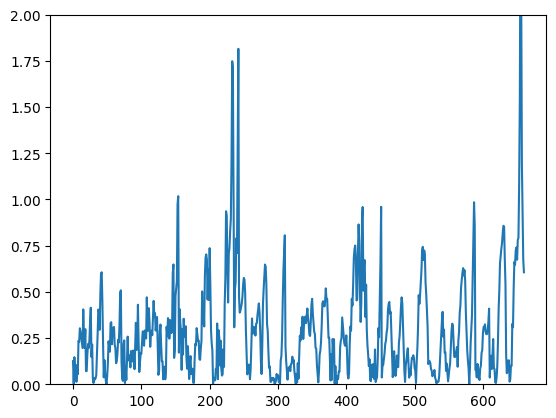

In [53]:
pl.figure()
# pl.plot(np.arange(len(dv_combined)), dv_combined, ls='-' )
# pl.plot(np.arange(len(dv_combined)), theory_combined, ls='--' )

pl.plot(np.arange(len(dv_combined)), np.abs(dv_combined-theory_combined)/sigma_value_combined, ls='-' )
# pl.plot(np.arange(len(dv_combined)), theory_combined, ls='--' )
pl.ylim(0.0, 2.0)
# pl.yscale('log')




Text(0, 0.5, '$P_e$ (${\\rm keV} / {\\rm cm}^3$)')

<Figure size 640x480 with 0 Axes>

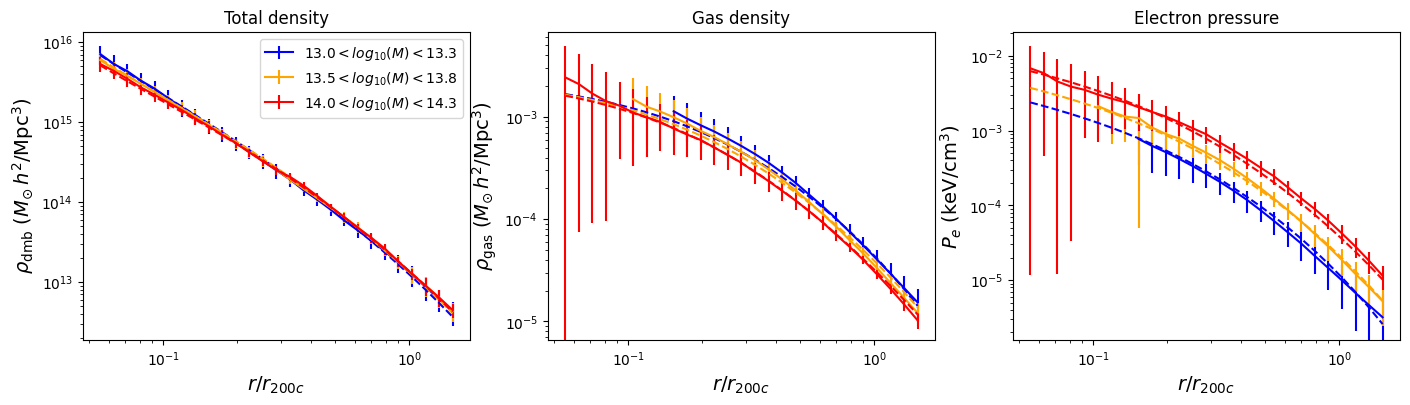

In [54]:
# # rho_dmb_dv.shape
indz = 0
pl.figure()
# set size of the figure:
pl.figure(figsize=(17, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
# pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[indz,0,:], (x_array_data**2)*sig_rho_dmb_dv[indz,0,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
# pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[indz,0,:],ls='--' , color='b' )

# pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[indz,1,:], (x_array_data**2)*sig_rho_dmb_dv[indz,1,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
# pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[indz,1,:],ls='--', color='orange' )

# pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[indz,2,:], (x_array_data**2)*sig_rho_dmb_dv[indz,2,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
# pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[indz,2,:],ls='--', color='r' )

pl.errorbar(x_array_data, rho_dmb_dv[indz,0,:], sig_rho_dmb_dv[indz,0,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, rho_dmb_dv_th_bf[indz,0,:],ls='--' , color='b' )

pl.errorbar(x_array_data, rho_dmb_dv[indz,1,:], sig_rho_dmb_dv[indz,1,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, rho_dmb_dv_th_bf[indz,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, rho_dmb_dv[indz,2,:], sig_rho_dmb_dv[indz,2,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
pl.errorbar(x_array_data, rho_dmb_dv_th_bf[indz,2,:],ls='--', color='r' )

pl.title('Total density')
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
pl.errorbar(x_array_data, ne_dv[indz,0,:], sig_ne_dv[indz,0,:],ls='-' , color='b', label='Total mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[indz,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, ne_dv[indz,1,:], sig_ne_dv[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[indz,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, ne_dv[indz,2,:], sig_ne_dv[indz,2,:],ls='-', color='r', label='Gas mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[indz,2,:],ls='--', color='r' )

pl.title('Gas density')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e15)
pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
pl.errorbar(x_array_data, Pe_dv[indz,0,:], sig_Pe_gas_dv[indz,0,:],ls='-' , color='b', label='Total mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[indz,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, Pe_dv[indz,1,:], sig_Pe_gas_dv[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[indz,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, Pe_dv[indz,2,:], sig_Pe_gas_dv[indz,2,:],ls='-', color='r', label='Gas mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[indz,2,:],ls='--', color='r' )



pl.title('Electron pressure')
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(2.9e-5, 1.1e-1)
# pl.legend()






Text(0, 0.5, '$P_e/P^{\\rm bestfit}_e$')

<Figure size 640x480 with 0 Axes>

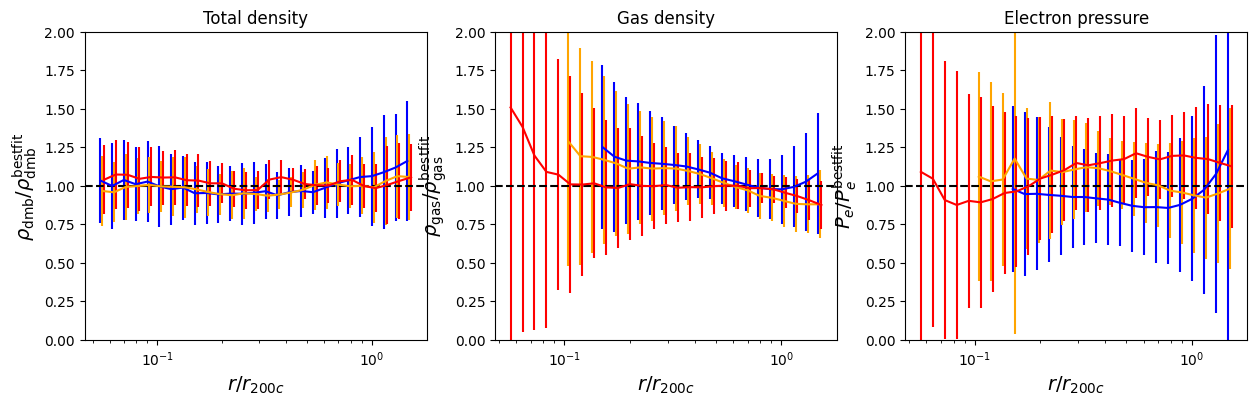

In [55]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
pl.errorbar(0.98*x_array_data, rho_dmb_dv[indz,0,:]/rho_dmb_dv_th_bf[indz,0,:], sig_rho_dmb_dv[indz,0,:]/rho_dmb_dv_th_bf[indz,0,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,0,:],ls='--' , color='b' )

pl.errorbar(x_array_data, rho_dmb_dv[indz,1,:]/rho_dmb_dv_th_bf[indz,1,:], sig_rho_dmb_dv[indz,1,:]/rho_dmb_dv_th_bf[indz,1,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(1.02*x_array_data, rho_dmb_dv[indz,2,:]/rho_dmb_dv_th_bf[indz,2,:], sig_rho_dmb_dv[indz,2,:]/rho_dmb_dv_th_bf[indz,2,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,2,:],ls='--', color='r' )

pl.axhline(1, ls='--', color='k')

pl.title('Total density')
# pl.legend()
pl.xscale('log')
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
pl.ylim(0.0, 2.0)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}/\rho^{\rm bestfit}_{\rm dmb}$', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
pl.errorbar(0.98*x_array_data, ne_dv[indz,0,:]/rho_gas_dv_th_bf[indz,0,:], sig_ne_dv[indz,0,:]/rho_gas_dv_th_bf[indz,0,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, ne_dv[indz,1,:]/rho_gas_dv_th_bf[indz,1,:], sig_ne_dv[indz,1,:]/rho_gas_dv_th_bf[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(1.02*x_array_data, ne_dv[indz,2,:]/rho_gas_dv_th_bf[indz,2,:], sig_ne_dv[indz,2,:]/rho_gas_dv_th_bf[indz,2,:],ls='-', color='r', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,2,:],ls='--', color='r' )
pl.axhline(1, ls='--', color='k')
pl.title('Gas density')
pl.xscale('log')
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
pl.ylim(0.0, 2.0)
pl.ylabel(r'$\rho_{\rm gas}/\rho^{\rm bestfit}_{\rm gas}$', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
pl.errorbar(0.98*x_array_data, Pe_dv[indz,0,:]/Pth_gas_dv_th_bf[indz,0,:], sig_Pe_gas_dv[indz,0,:]/Pth_gas_dv_th_bf[indz,0,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, Pe_dv[indz,1,:]/Pth_gas_dv_th_bf[indz,1,:], sig_Pe_gas_dv[indz,1,:]/Pth_gas_dv_th_bf[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(1.02*x_array_data, Pe_dv[indz,2,:]/Pth_gas_dv_th_bf[indz,2,:], sig_Pe_gas_dv[indz,2,:]/Pth_gas_dv_th_bf[indz,2,:],ls='-', color='r', label='Gas mass, sims')
# pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,2,:],ls='--', color='r' )
pl.axhline(1, ls='--', color='k')


pl.title('Electron pressure')
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.ylim(0.0, 2.0)
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
pl.ylabel(r'$P_e/P^{\rm bestfit}_e$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()






In [229]:
minimum = jnp.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = jnp.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic_loss(x):
  return jnp.sum(scales * jnp.square(x - minimum))

start = jnp.array([0.6, 0.8])  # Starting point for the search.

optim_results = tfp.optimizer.lbfgs_minimize(
    value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)




Function evaluations: 5


In [230]:
from numpyro.distributions.transforms import AffineTransform
import numpyro.distributions as dist
import numpyro
def Uniform(name, min_value, max_value):
    """ Creates a Uniform distribution in target range from a base
    distribution between [-3, 3]
    """
    s = (max_value - min_value) / 6.
    return numpyro.sample(
            name,
            dist.TransformedDistribution(
                dist.Uniform(-3., 3.),
                AffineTransform(min_value + 3.*s, s),
            ),
        )


In [58]:
# from get_corr_func_jit import get_corrfunc_BCMP
from get_BCMP_profile_jit import BCM_18_wP
import numpyro
import copy
from jax_cosmo.scipy.interpolate import interp
def model():
    #  Cosmological params
    # theta_ej = Uniform('theta_ej', 1.0, 8.0)
    # theta_co = Uniform('theta_co', 0.0001, 0.8)

    theta_ej_0 = Uniform('theta_ej_0', 0.0001, 8.0)
    nu_theta_ej_M = Uniform('nu_theta_ej_M', -1.0, 1.0)    
    nu_theta_ej_z = Uniform('nu_theta_ej_z', -1.0, 1.0)    

    theta_co_0 = Uniform('theta_co_0', 0.0001, 0.8)
    nu_theta_co_M = Uniform('nu_theta_co_M', -1.0, 1.0)    

    log10_Mc0 = Uniform('log10_Mc0', 10.0, 16.0)
    gamma_rhogas = Uniform('gamma_rhogas', 0.01, 8.0)
    delta_rhogas = Uniform('delta_rhogas', 0.01, 15.0)
    mu_beta = Uniform('mu_beta', -0.3, 0.8)    
    nu_z = Uniform('nu_z', -1.0, 1.0)

    eta_star = Uniform('eta_star', 0.05, 0.8)
    eta_cga = Uniform('eta_cga', 0.3, 1.0)


    # beta_nt = Uniform('beta_nt', 0.0, 1.0)
    # eta_star = Uniform('eta_star', 0.05, 0.8)
    # eta_cga = Uniform('eta_cga', 0.4, 1.0)
    # log10_M1_starcga = Uniform('log10_M1_starcga', 11.0, 12.0)

    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    # sim_params_dict_vary['theta_ej'] = theta_ej
    # sim_params_dict_vary['theta_co'] = theta_co

    sim_params_dict_vary['theta_ej_0'] = theta_ej_0
    sim_params_dict_vary['nu_theta_ej_M'] = nu_theta_ej_M    
    sim_params_dict_vary['theta_co_0'] = theta_co_0
    sim_params_dict_vary['nu_theta_co_M'] = nu_theta_co_M     

    sim_params_dict_vary['nu_theta_ej_z'] = nu_theta_ej_z
    sim_params_dict_vary['nu_z'] = nu_z   

    sim_params_dict_vary['log10_Mc0'] = log10_Mc0
    sim_params_dict_vary['gamma_rhogas'] = gamma_rhogas
    sim_params_dict_vary['delta_rhogas'] = delta_rhogas
    sim_params_dict_vary['mu_beta'] = mu_beta
    # sim_params_dict_vary['beta_nt'] = beta_nt
    sim_params_dict_vary['eta_star'] = eta_star  
    sim_params_dict_vary['eta_cga'] = eta_cga
    # sim_params_dict_vary['log10_M1_starcga'] = log10_M1_starcga
    
    # Now that params are defined, here is the forward model
    # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
    # theory = BCMP_test_vary.rho_dmb_mat

    rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
    rho_gas = BCMP_test_vary.rho_gas_mat_physical
    Pe_gas = BCMP_test_vary.Pe_mat_physical
    
    def interp_rho_dmb(jc, jz, jM):
        rho_dmb_here = rho_dmb[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out


    def interp_rho_gas(jc, jz, jM):
        rho_dmb_here = rho_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out


    def interp_Pe_gas(jc, jz, jM):
        rho_dmb_here = Pe_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_rho_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    def get_mean_rhodmb(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_dmb_rM = rhodmb_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        return rho_dmb_mean

    def get_mean_rhogas(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_gas_rM = rhogas_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        return rho_gas_mean

    def get_mean_Pe(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pe_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean


    vmap_func1 = vmap(get_mean_rhodmb, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhogas, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pe, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

    dmb_dv_flatten = rho_dmb_dv_th.flatten()
    gas_dv_flatten = rho_gas_dv_th.flatten()
    Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

    theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
    # theory_combined = jnp.log(theory_combined)

    return numpyro.sample('cl', dist.MultivariateNormal(theory_combined, 
                                                        precision_matrix=precision_combined,
                                                        covariance_matrix=cov_combined))






In [59]:
# cov_combined
# !pip install numpyro



In [60]:
from numpyro.handlers import seed, trace, condition
# Now we condition the model on obervations
observed_model = condition(model, {'cl': dv_combined})



In [61]:
import numpyro
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

observed_model_reparam = numpyro.handlers.reparam(observed_model, config=config)




In [67]:
nuts_kernel = numpyro.infer.NUTS(observed_model_reparam,
                                 step_size=1.0, 
                                 init_strategy=numpyro.infer.init_to_median,
                                 dense_mass=False,
                                 max_tree_depth=1)




In [68]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=200, 
                          num_samples=800,
                          num_chains=1,
                          chain_method='vectorized',
                        #   chain_method='sequential',                          
                          progress_bar=True)




In [69]:
numpyro.set_platform("gpu")



In [70]:
import jax

mcmc.run(jax.random.PRNGKey(42))




/tmp/ipykernel_703434/1625555328.py:110: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_703434/1625555328.py:122: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_703434/1625555328.py:134: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
sample: 100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s, 1 steps of size 9.31e-02. acc. prob=0.96]
/tmp/ipykernel_703434/1625555328.py:110: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = j

/tmp/ipykernel_703434/580718698.py:110: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_703434/580718698.py:122: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_703434/580718698.py:134: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]


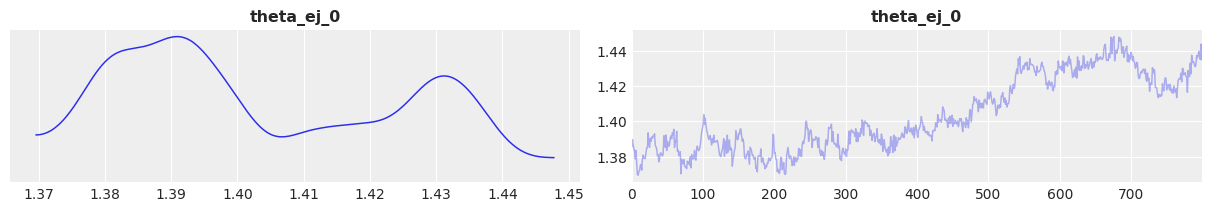

In [43]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, var_names=['theta_ej_0']);






In [44]:
az.ess(data)



<xarray.Dataset>
Dimensions:             ()
Data variables: (12/20)
    eta_cga             float64 1.308
    eta_cga_base        float64 1.308
    eta_star            float64 1.305
    eta_star_base       float64 1.305
    log10_Mc0           float64 1.324
    log10_Mc0_base      float64 1.324
    ...                  ...
    nu_z                float64 3.177
    nu_z_base           float64 3.177
    theta_co_0          float64 1.308
    theta_co_0_base     float64 1.308
    theta_ej_0          float64 1.349
    theta_ej_0_base     float64 1.349

In [293]:
az.ess(data)



<xarray.Dataset>
Dimensions:             ()
Data variables: (12/24)
    delta_rhogas        float64 2.526
    delta_rhogas_base   float64 2.526
    eta_cga             float64 1.458
    eta_cga_base        float64 1.458
    eta_star            float64 1.463
    eta_star_base       float64 1.463
    ...                  ...
    nu_z                float64 1.59
    nu_z_base           float64 1.59
    theta_co_0          float64 3.912
    theta_co_0_base     float64 3.912
    theta_ej_0          float64 3.209
    theta_ej_0_base     float64 3.209

array([<Axes: title={'center': 'theta_ej_0\n0'}>,
       <Axes: title={'center': 'log10_Mc0\n0'}>], dtype=object)

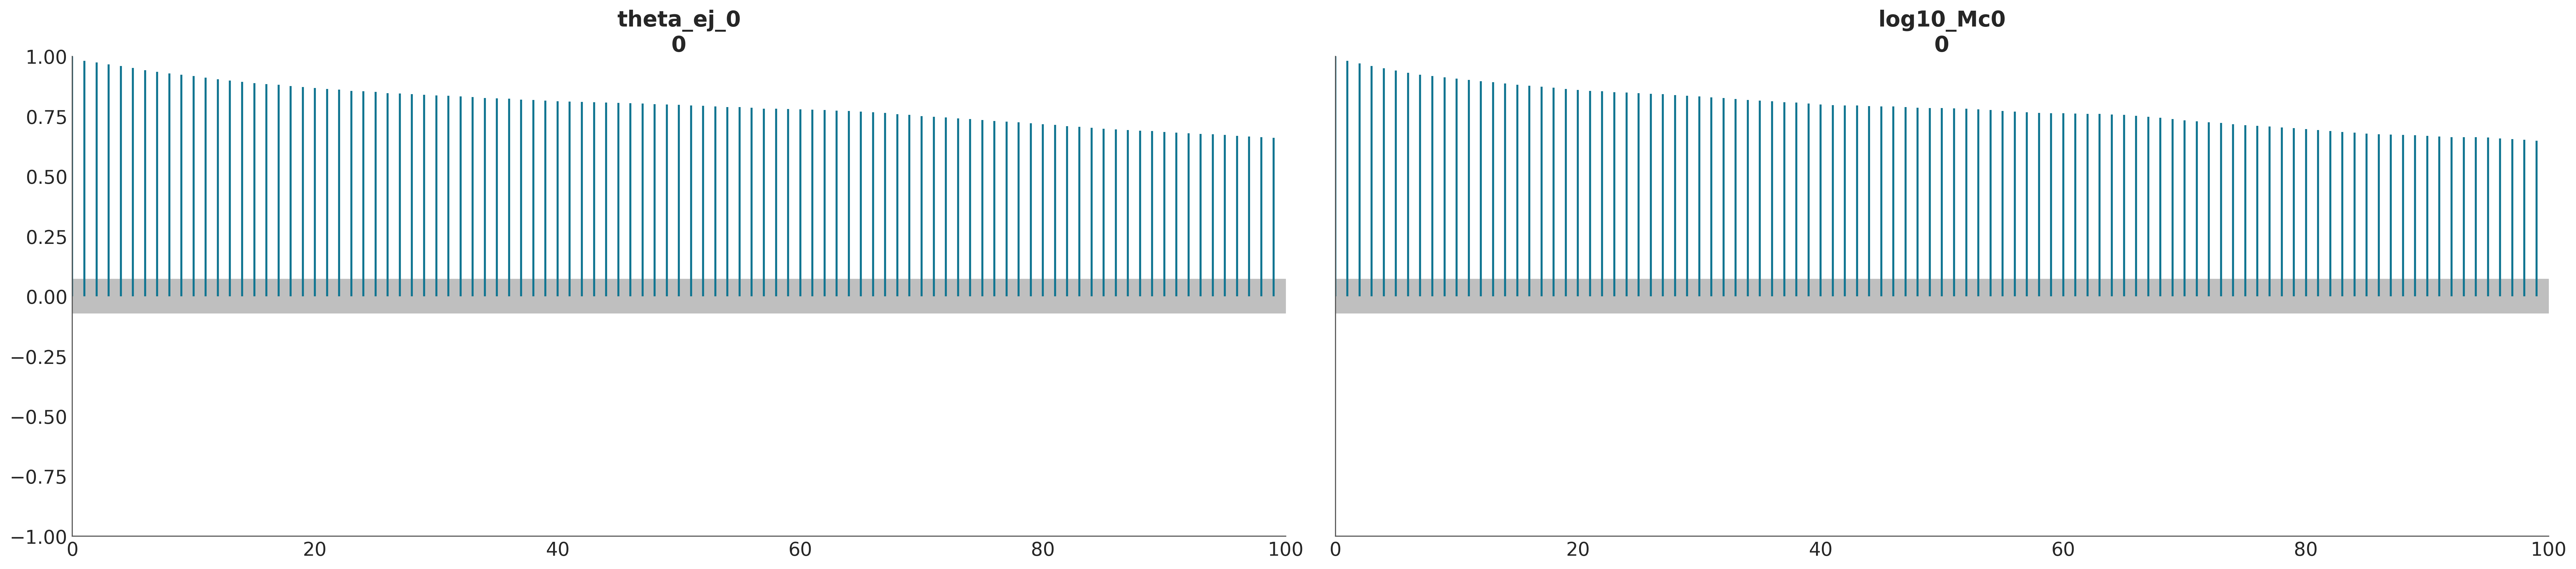

In [45]:
import arviz as az

az.style.use("arviz-doc")

# data = az.load_arviz_data("centered_eight")
az.plot_autocorr(data, var_names=('theta_ej_0', 'log10_Mc0'))
# az.plot_autocorr(data, var_names=('delta_rhogas', 'gamma_rhogas'))
# az.plot_posterior(data, var_names=('delta_rhogas', 'gamma_rhogas'))

# plt.show()


In [46]:
s = mcmc.get_samples()
s.keys()
# len(s['delta_rhogas'])

import pickle as pk
# pk.dump(s, open('s_1chain_500samples_300warmup.pkl', 'wb'))
# pk.dump(s, open('s_1chain_1000samples_500warmup_nchains4.pkl', 'wb'))




In [47]:
s['theta_ej_0'].shape


(800,)

In [48]:
mcmc.print_summary()

    # sim_params_dict_vary['theta_ej'] = theta_ej
    # sim_params_dict_vary['log10_Mc0'] = log10_Mc0
    # sim_params_dict_vary['gamma_rhogas'] = gamma_rhogas
    # sim_params_dict_vary['delta_rhogas'] = delta_rhogas
    # sim_params_dict_vary['eta_star'] = eta_star  
    # sim_params_dict_vary['eta_cga'] = eta_cga
    # sim_params_dict_vary['log10_M1_starcga'] = log10_M1_starcga

    
    


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
        eta_cga_base     -0.77      0.01     -0.77     -0.79     -0.76      2.32      3.48
       eta_star_base     -0.69      0.20     -0.68     -0.98     -0.37      2.54      2.58
      log10_Mc0_base      0.65      0.04      0.66      0.59      0.71      2.59      2.55
        mu_beta_base      1.24      0.01      1.24      1.22      1.26      2.72      2.36
  nu_theta_co_M_base     -1.12      0.01     -1.12     -1.14     -1.11      2.46      3.16
  nu_theta_ej_M_base      0.03      0.01      0.03      0.01      0.05      3.17      2.18
  nu_theta_ej_z_base     -1.87      0.03     -1.86     -1.92     -1.82      4.84      1.38
           nu_z_base     -0.28      0.00     -0.28     -0.28     -0.28      8.13      1.23
     theta_co_0_base     -1.52      0.02     -1.52     -1.55     -1.49      2.62      2.38
     theta_ej_0_base     -1.95      0.02     -1.95     -1.97     -1.92      2.69      2.4

array([[<Axes: >, None],
       [<Axes: xlabel='theta_ej_0', ylabel='log10_Mc0'>, <Axes: >]],
      dtype=object)

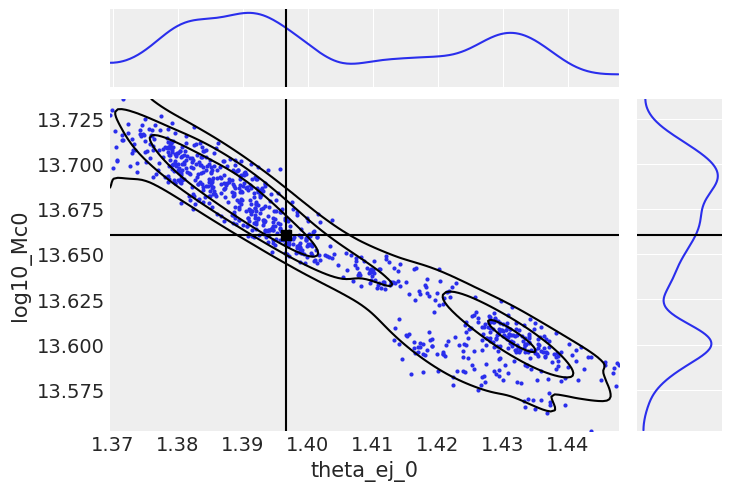

In [49]:
import arviz as az

az.style.use("arviz-darkgrid")

az.plot_pair(
    s,
    kind=["scatter", "kde"],
    var_names=['theta_ej_0', 'log10_Mc0'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
    point_estimate="median",
)



array([[<Axes: >, None],
       [<Axes: xlabel='theta_ej_0', ylabel='theta_co_0'>, <Axes: >]],
      dtype=object)

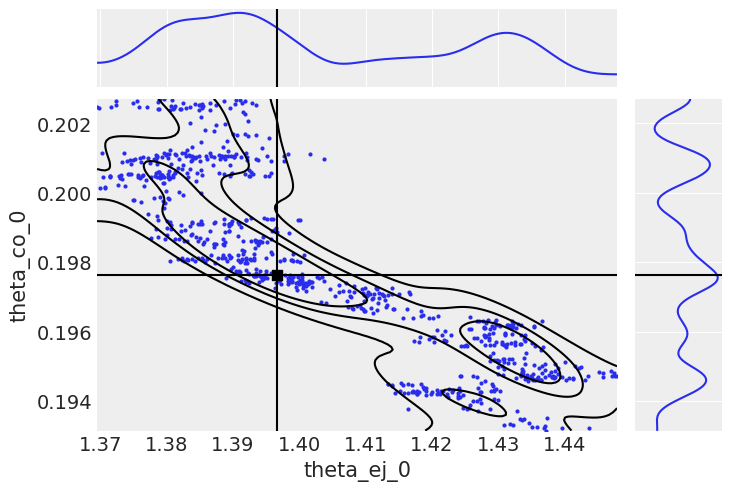

In [50]:
import arviz as az

az.style.use("arviz-darkgrid")

az.plot_pair(
    s,
    kind=["scatter", "kde"],
    var_names=['theta_ej_0', 'theta_co_0'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
    point_estimate="median",
)



In [51]:
def get_theory_at_params(theta_co_0, nu_theta_co_M, theta_ej_0, nu_theta_ej_M, log10_Mc0, 
                        #  delta_rhogas, gamma_rhogas, 
                         mu_beta, eta_star, eta_cga, nu_theta_ej_z, nu_z):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    # sim_params_dict_vary['theta_co'] = theta_co    
    # sim_params_dict_vary['theta_ej'] = theta_ej

    sim_params_dict_vary['theta_co_0'] = theta_co_0
    sim_params_dict_vary['nu_theta_co_M'] = nu_theta_co_M    
    sim_params_dict_vary['theta_ej_0'] = theta_ej_0
    sim_params_dict_vary['nu_theta_ej_M'] = nu_theta_ej_M       
    sim_params_dict_vary['nu_theta_ej_z'] = nu_theta_ej_z 
    sim_params_dict_vary['nu_z'] = nu_z

    sim_params_dict_vary['log10_Mc0'] = log10_Mc0
    # sim_params_dict_vary['gamma_rhogas'] = gamma_rhogas
    # sim_params_dict_vary['delta_rhogas'] = delta_rhogas
    sim_params_dict_vary['mu_beta'] = mu_beta
    sim_params_dict_vary['eta_star'] = eta_star  
    sim_params_dict_vary['eta_cga'] = eta_cga
    # sim_params_dict_vary['log10_M1_starcga'] = log10_M1_starcga
    # 
    # Now that params are defined, here is the forward model
    # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
    # theory = BCMP_test_vary.rho_dmb_mat

    rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
    rho_gas = BCMP_test_vary.rho_gas_mat_physical
    Pe_gas = BCMP_test_vary.Pe_mat_physical
    
    def interp_rho_dmb(jc, jz, jM):
        rho_dmb_here = rho_dmb[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out


    def interp_rho_gas(jc, jz, jM):
        rho_dmb_here = rho_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out


    def interp_Pe_gas(jc, jz, jM):
        rho_dmb_here = Pe_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_rho_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    def get_mean_rhodmb(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_dmb_rM = rhodmb_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        return rho_dmb_mean

    def get_mean_rhogas(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_gas_rM = rhogas_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        return rho_gas_mean

    def get_mean_Pe(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pe_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean


    vmap_func1 = vmap(get_mean_rhodmb, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhogas, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pe, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

    dmb_dv_flatten = rho_dmb_dv_th.flatten()
    gas_dv_flatten = rho_gas_dv_th.flatten()
    Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

    theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
    theory_combined = jnp.log(theory_combined)


    return rho_dmb_dv_th, rho_gas_dv_th, Pe_gas_dv_th, theory_combined



In [52]:
ind = -1
# rho_dmb_dv_th_bf, rho_gas_dv_th_bf, Pth_gas_dv_th_bf, theory_combined_bf = get_theory_at_params(s['theta_ej'][ind], s['log10_Mc0'][ind], s['delta_rhogas'][ind], s['gamma_rhogas'][ind], s['beta_nt'][ind])
# rho_dmb_dv_th_bf, rho_gas_dv_th_bf, Pth_gas_dv_th_bf, theory_combined_bf = get_theory_at_params(s['theta_ej'][ind], s['log10_Mc0'][ind], s['delta_rhogas'][ind], s['gamma_rhogas'][ind])
rho_dmb_dv_th_bf, rho_gas_dv_th_bf, Pth_gas_dv_th_bf, theory_combined_bf = get_theory_at_params(s['theta_co_0'][ind],s['nu_theta_co_M'][ind], \
    s['theta_ej_0'][ind],s['nu_theta_ej_M'][ind], s['log10_Mc0'][ind], \
    # s['delta_rhogas'][ind], s['gamma_rhogas'][ind], 
    s['mu_beta'][ind],
    s['eta_star'][ind], s['eta_cga'][ind], s['nu_theta_ej_z'][ind], s['nu_z'][ind])




/tmp/ipykernel_703434/1855577234.py:79: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_703434/1855577234.py:91: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_703434/1855577234.py:103: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]


In [53]:
rho_dmb_dv_th_bf.shape



(3, 3, 27)

In [54]:
# # # rho_dmb_dv.shape

# pl.figure()
# # add subplot to the left:
# pl.subplot(1, 2, 1)
# pl.errorbar(x_array_data, rho_dmb_dv[0,0,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,0,:],ls='--' , color='b' , label='Theory')

# pl.errorbar(x_array_data, rho_gas_dv[0,0,:],ls='-', color='r', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,0,:],ls='--', color='r' )
# pl.title('Low mass bin')
# pl.xscale('log')
# pl.yscale('log')
# pl.xlabel(r'$r/r_{200c}$', size=14)
# # pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.ylabel(r'$\rho$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)


# # add subplot to the right:
# pl.subplot(1, 2, 2)
# pl.errorbar(x_array_data, rho_dmb_dv[0,1,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,1,:],ls='--' , color='b' , label='Theory')

# pl.errorbar(x_array_data, rho_gas_dv[0,1,:],ls='-', color='r', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,1,:],ls='--', color='r' )
# pl.title('High mass bin')


# # pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# # pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
# pl.xscale('log')
# pl.yscale('log')
# pl.xlabel(r'$r/r_{200c}$', size=14)
# # pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()




In [55]:
# Pth_gas_dv_th_bf.shape


Text(0, 0.5, '$P_e$ (${\\rm keV} / {\\rm cm}^3$)')

<Figure size 720x480 with 0 Axes>

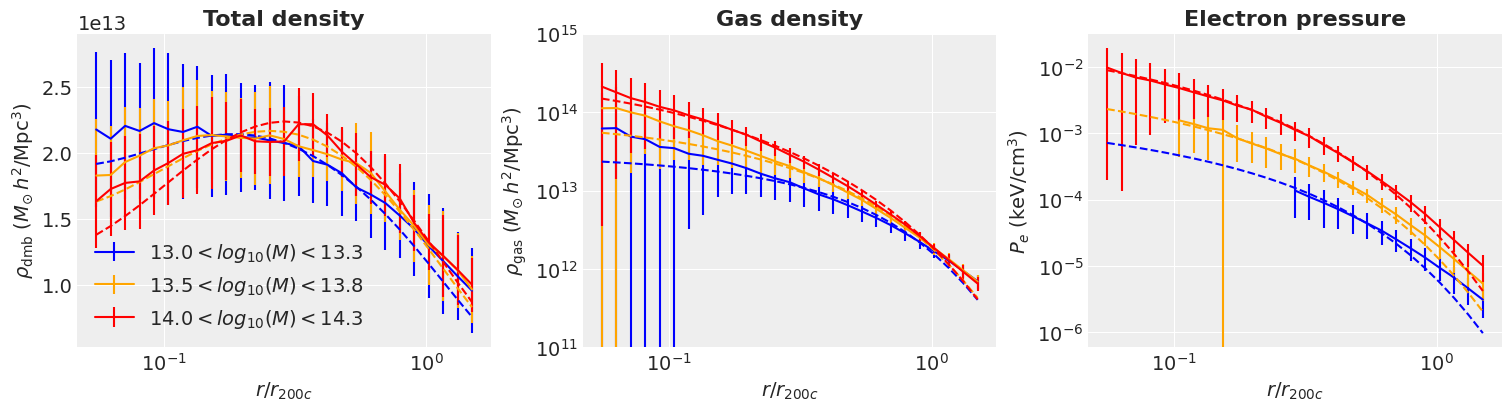

In [56]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,0,:], (x_array_data**2)*sig_rho_dmb_dv[0,0,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[0,0,:],ls='--' , color='b' )

pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,1,:], (x_array_data**2)*sig_rho_dmb_dv[0,1,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,2,:], (x_array_data**2)*sig_rho_dmb_dv[0,2,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[0,2,:],ls='--', color='r' )

pl.title('Total density')
pl.legend()
pl.xscale('log')
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
pl.errorbar(x_array_data, rho_gas_dv[0,0,:], sig_rho_gas_dv[0,0,:],ls='-' , color='b', label='Total mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, rho_gas_dv[0,1,:], sig_rho_gas_dv[0,1,:],ls='-', color='orange', label='Gas mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, rho_gas_dv[0,2,:], sig_rho_gas_dv[0,2,:],ls='-', color='r', label='Gas mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,2,:],ls='--', color='r' )

pl.title('Gas density')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
pl.ylim(1e11, 1e15)
pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
pl.errorbar(x_array_data, P_gas_dv[0,0,:], sig_P_gas_dv[0,0,:],ls='-' , color='b', label='Total mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, P_gas_dv[0,1,:], sig_P_gas_dv[0,1,:],ls='-', color='orange', label='Gas mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, P_gas_dv[0,2,:], sig_P_gas_dv[0,2,:],ls='-', color='r', label='Gas mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,2,:],ls='--', color='r' )



pl.title('Electron pressure')
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()






Text(0, 0.5, '$P_e$ (${\\rm keV} / {\\rm cm}^3$)')

<Figure size 720x480 with 0 Axes>

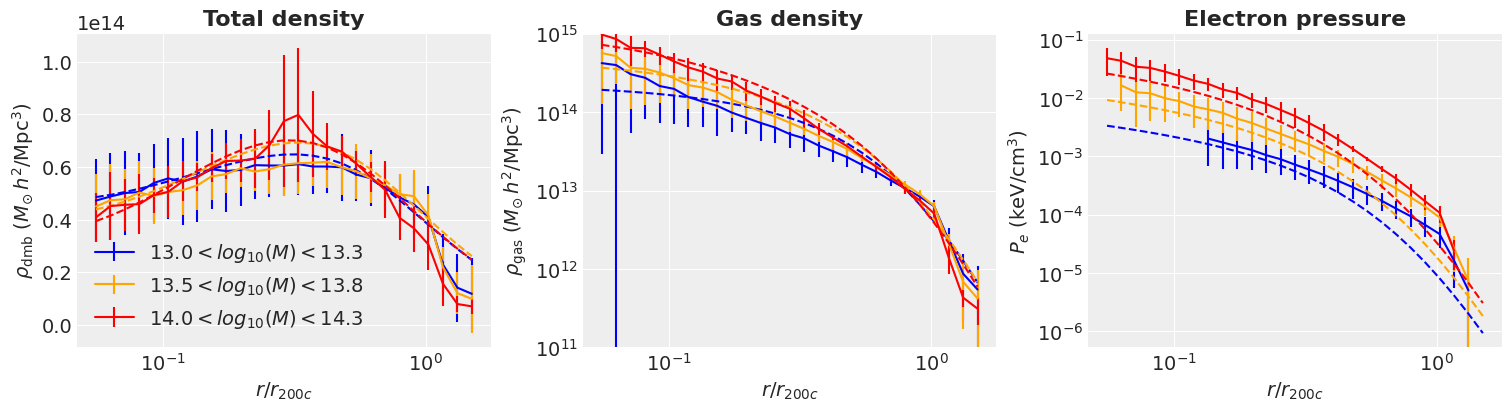

In [57]:
# # rho_dmb_dv.shape
indz = 2
pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[indz,0,:], (x_array_data**2)*sig_rho_dmb_dv[indz,0,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[indz,0,:],ls='--' , color='b' )

pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[indz,1,:], (x_array_data**2)*sig_rho_dmb_dv[indz,1,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[indz,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[indz,2,:], (x_array_data**2)*sig_rho_dmb_dv[indz,2,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv_th_bf[indz,2,:],ls='--', color='r' )

pl.title('Total density')
pl.legend()
pl.xscale('log')
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
pl.errorbar(x_array_data, rho_gas_dv[indz,0,:], sig_rho_gas_dv[indz,0,:],ls='-' , color='b', label='Total mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[2,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, rho_gas_dv[indz,1,:], sig_rho_gas_dv[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[2,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, rho_gas_dv[indz,2,:], sig_rho_gas_dv[indz,2,:],ls='-', color='r', label='Gas mass, sims')
pl.errorbar(x_array_data, rho_gas_dv_th_bf[2,2,:],ls='--', color='r' )

pl.title('Gas density')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
pl.ylim(1e11, 1e15)
pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
pl.errorbar(x_array_data, P_gas_dv[indz,0,:], sig_P_gas_dv[indz,0,:],ls='-' , color='b', label='Total mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[2,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, P_gas_dv[indz,1,:], sig_P_gas_dv[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[2,1,:],ls='--', color='orange' )

pl.errorbar(x_array_data, P_gas_dv[indz,2,:], sig_P_gas_dv[indz,2,:],ls='-', color='r', label='Gas mass, sims')
pl.errorbar(x_array_data, Pth_gas_dv_th_bf[2,2,:],ls='--', color='r' )



pl.title('Electron pressure')
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()






Text(0, 0.5, '$P_e/P^{\\rm bestfit}_e$')

<Figure size 720x480 with 0 Axes>

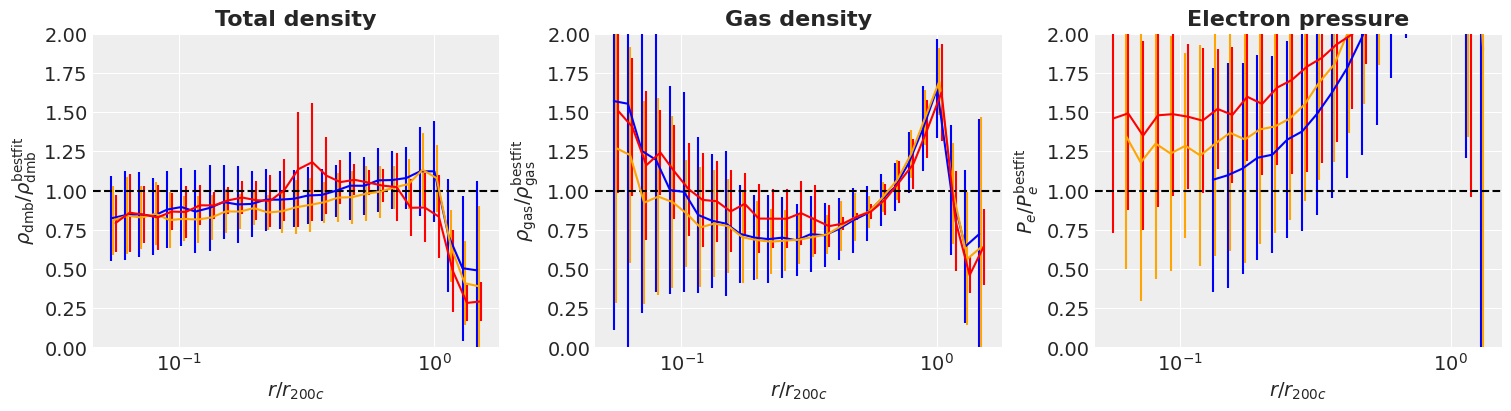

In [308]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
pl.errorbar(0.98*x_array_data, rho_dmb_dv[indz,0,:]/rho_dmb_dv_th_bf[indz,0,:], sig_rho_dmb_dv[indz,0,:]/rho_dmb_dv_th_bf[indz,0,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,0,:],ls='--' , color='b' )

pl.errorbar(x_array_data, rho_dmb_dv[indz,1,:]/rho_dmb_dv_th_bf[indz,1,:], sig_rho_dmb_dv[indz,1,:]/rho_dmb_dv_th_bf[indz,1,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(1.02*x_array_data, rho_dmb_dv[indz,2,:]/rho_dmb_dv_th_bf[indz,2,:], sig_rho_dmb_dv[indz,2,:]/rho_dmb_dv_th_bf[indz,2,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
# pl.errorbar(x_array_data, rho_dmb_dv_th_bf[0,2,:],ls='--', color='r' )

pl.axhline(1, ls='--', color='k')

pl.title('Total density')
# pl.legend()
pl.xscale('log')
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
pl.ylim(0.0, 2.0)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}/\rho^{\rm bestfit}_{\rm dmb}$', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
pl.errorbar(0.98*x_array_data, rho_gas_dv[indz,0,:]/rho_gas_dv_th_bf[indz,0,:], sig_rho_gas_dv[indz,0,:]/rho_gas_dv_th_bf[indz,0,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, rho_gas_dv[indz,1,:]/rho_gas_dv_th_bf[indz,1,:], sig_rho_gas_dv[indz,1,:]/rho_gas_dv_th_bf[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(1.02*x_array_data, rho_gas_dv[indz,2,:]/rho_gas_dv_th_bf[indz,2,:], sig_rho_gas_dv[indz,2,:]/rho_gas_dv_th_bf[indz,2,:],ls='-', color='r', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv_th_bf[0,2,:],ls='--', color='r' )
pl.axhline(1, ls='--', color='k')
pl.title('Gas density')
pl.xscale('log')
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
pl.ylim(0.0, 2.0)
pl.ylabel(r'$\rho_{\rm gas}/\rho^{\rm bestfit}_{\rm gas}$', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
pl.errorbar(0.98*x_array_data, P_gas_dv[indz,0,:]/Pth_gas_dv_th_bf[indz,0,:], sig_P_gas_dv[indz,0,:]/Pth_gas_dv_th_bf[indz,0,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,0,:],ls='--' , color='b' , label='Theory')

pl.errorbar(x_array_data, P_gas_dv[indz,1,:]/Pth_gas_dv_th_bf[indz,1,:], sig_P_gas_dv[indz,1,:]/Pth_gas_dv_th_bf[indz,1,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,1,:],ls='--', color='orange' )

pl.errorbar(1.02*x_array_data, P_gas_dv[indz,2,:]/Pth_gas_dv_th_bf[indz,2,:], sig_P_gas_dv[indz,2,:]/Pth_gas_dv_th_bf[indz,2,:],ls='-', color='r', label='Gas mass, sims')
# pl.errorbar(x_array_data, Pth_gas_dv_th_bf[0,2,:],ls='--', color='r' )
pl.axhline(1, ls='--', color='k')


pl.title('Electron pressure')
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.ylim(0.0, 2.0)
# pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
pl.ylabel(r'$P_e/P^{\rm bestfit}_e$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()






In [ ]:
import matplotlib
import sys
if not hasattr(sys, 'ps1'): 
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pandas as pd
from scipy import stats
import numpy as np
import os
import glob
import sys

def plot_density_profiles(sim_dir, snap_num, axs, **kwargs):

    # Read radial bins
    rbins = np.loadtxt(f'{sim_dir}/data/profiles_{str(snap_num).zfill(3)}_rbins.txt')

    # Read halos
    halos = pd.read_csv(f'{sim_dir}/data/profiles_{str(snap_num).zfill(3)}_halos.csv')
    # print(halos)

    # Read pressure profiles
    dm_profiles = pd.read_csv(f'{sim_dir}/data/profiles_{str(snap_num).zfill(3)}_rho_dm.csv')
    gas_profiles = pd.read_csv(f'{sim_dir}/data/profiles_{str(snap_num).zfill(3)}_rho_gas.csv')
    stars_profiles = pd.read_csv(f'{sim_dir}/data/profiles_{str(snap_num).zfill(3)}_rho_stars.csv')

    # Make a selection based on halo mass
    mask = np.where(halos.m200 >= 1e14)
    selection_dm = dm_profiles.iloc[mask]
    selection_gas = gas_profiles.iloc[mask]
    selection_stars = stars_profiles.iloc[mask]

    ax0, ax1 = axs
    ax0.plot(rbins,  selection_dm.mean(), **kwargs, ls='-')
    ax0.plot(rbins,  selection_gas.mean(), **kwargs, ls='--', dashes=(10, 10))
    # ax0.plot(rbins,  selection_stars.mean(), **kwargs, ls=':')

    ax1.plot(rbins,  selection_dm.mean() * rbins ** 2, **kwargs, ls='-')
    ax1.plot(rbins,  selection_gas.mean() * rbins ** 2, **kwargs, ls='--', dashes=(10, 10))
    # ax1.plot(rbins,  selection_stars.mean() * rbins ** 2, **kwargs, ls=':')


if __name__ == '__main__':

    gs = gridspec.GridSpec(2, 1, hspace=0.05, height_ratios=[1, 0.75])

    fig = plt.figure(figsize=(5, 6))
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])    

    snap = 32 # Redshift z = 0.

    sim_datasets = ['HYDRO_GADGET', 'HYDRO_ANARCHY']

    for index, dataset in enumerate(sim_datasets):
        color = f'C{index}'

        # Give main data directory. 
        data_dir = f'/cosma7old/data/dp004/fkgm22/ANTILLES/L100N256/WMAP9/{dataset}/Sims/'

        # List all simulations inside the directory:
        sims = list(filter(os.path.isdir, glob.glob(f'{data_dir}*')))

        # Plot all sims:
        for i in sims:
            print(i)
            plot_density_profiles(i, snap, [ax0, ax1], c=color, alpha=0.5, lw=0.75)

    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_xlim(.03,2)
    ax0.set_xticklabels([])
    ax0.set_ylim(1e12,2e16)   
    ax0.set_ylabel('$\\rho (r)\\,\\, [\\mathrm{M}_\\odot \\, h^{2} \\mathrm{Mpc}^{-3}]$')

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(.03,2)
    ax1.set_ylim(1e11,5e13) 
    ax1.set_xlabel('$r/r_{200}$')
    ax1.set_ylabel('$\\rho (r) \\, (r/r_{200})^{2} \\,\\, [\\mathrm{M}_\\odot \\, h^{2} \\mathrm{Mpc}^{-3}]$')
    gs.tight_layout(fig)
    fig.savefig('density_profiles.pdf')

In [16]:
from scipy.special import loggamma
import numpy as np
# create a grid of complex numbers over -5 to 5:
x = np.linspace(0, 50, 100)
y = np.linspace(0, 50, 100)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

lg_Z = loggamma(Z)



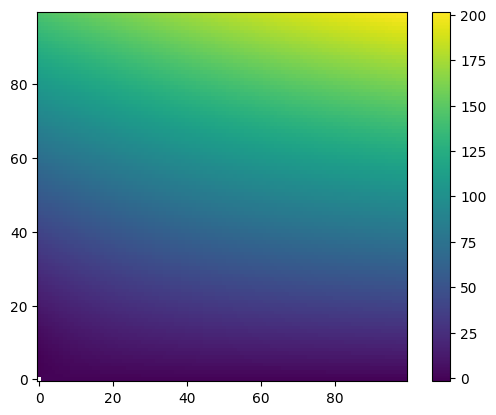

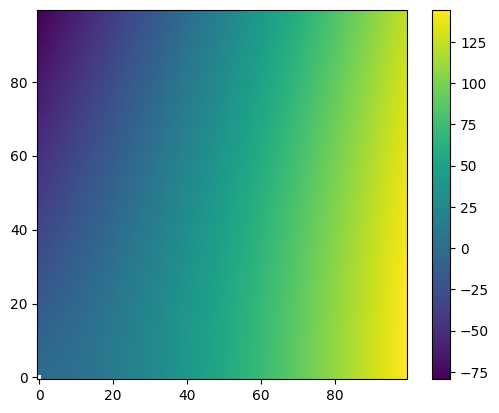

In [21]:
# lg_Z.shape
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.figure()
pl.imshow(lg_Z.imag, origin='lower')
pl.colorbar()
pl.figure()
pl.imshow(lg_Z.real, origin='lower')
pl.colorbar()


In [12]:
# lg_Z.real
import mcfit



In [15]:
import math
x_array = np.logspace(-2, 2, 100)
Nin, N_imag = len(x_array), 2
folds = np.ceil(np.log2(Nin * N_imag)) // 1
N = 2**folds
m = np.arange(0, N//2 + 1)
Delta = np.log(x_array[-1] / x_array[0]) / (Nin - 1)
imag_part = 2 * math.pi / N / Delta * m
print(np.amin(imag_part), np.amax(imag_part))



0.0 33.76831475758558
